# MODULO 02 - PROJETO DE MACHINE LEARNING - DIABETES

---

## CONTEXTUALIZAÇÃO DO PROBLEMA

A **diabetes** é uma das maiores ameaças à saúde pública global: é crônica, progressiva e responsável por grande parte dos custos hospitalares, perda de produtividade e redução da qualidade de vida. Detectá-la cedo transforma cuidados clínicos, reduz complicações evitáveis e otimiza alocação de recursos em saúde, por isso modelos preditivos bem calibrados podem funcionar como ferramentas de triagem que ampliam o alcance de equipes médicas e programas preventivos.

Este projeto tem como objetivo construir um serviço de inferência que preveja **a presença de diabetes (classe 1)** a partir de features clínicos e demográficas, unindo técnicas de pré-processamento, balanceamento e aprendizado de máquina para entregar previsões confiáveis, interpretáveis e acionáveis. Ao transformar dados em alertas clínicos, o sistema pode priorizar pacientes para exames adicionais, orientar intervenções precoces e reduzir custos e danos associados a diagnósticos tardios.

**Benefícios esperados:**

- **Detecção precoce:** aumentar a sensibilidade para identificar casos reais.

- **Eficiência clínica:** priorização de pacientes de alto risco para testes confirmatórios.

- **Redução de custos:** evitar hospitalizações e complicações caras por diagnóstico tardio.

- **Transparência:** fornecer explicações e importâncias de variáveis para suporte clínico.

Será utilizada uma base de dados disponível no Kaggle:
- [**Diabetes Dataset from Kaggle** -
Ayushman Yashaswi](https://www.kaggle.com/datasets/ayushmanyashaswi/diabetes-dataset-from-kaggle)

Para realizar o download localmente, execute o comando abaixo:
```bash
#!/bin/bash
curl -L -o ~/Downloads/diabetes-dataset-from-kaggle.zip\
  https://www.kaggle.com/api/v1/datasets/download/ayushmanyashaswi/diabetes-dataset-from-kaggle
```

## 1. IMPORTAÇÃO DAS BIBLIOTECAS

In [1]:
# suprimir warning
import warnings
warnings.filterwarnings('ignore')

# imports para baixar e carregar a base de dados
import urllib
from zipfile import ZipFile

# imports para manipulação da base de dados
import pandas as pd
import numpy as np

# imports para plotagem de gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# import para fixar seed e permitir reproducao de resultados
import random
random.seed(42) #

# import para fazer tratamento de valores ausentes/missing values
from sklearn.impute import SimpleImputer

# imports para pre-processamento dos dados (normalização, subst. de variaveis categoricas por numericas)
# pipelines para evitar data leakage
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# import para Analise de Componentes Principais
from sklearn.decomposition import PCA

# import para dividir os dados para uso em treino e teste
from sklearn.model_selection import train_test_split

# import dos modelos de machine learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# instala direto no notebook
import sys
!{sys.executable} -m pip install xgboost==3.0.0
!{sys.executable} -m pip install lightgbm
!{sys.executable} -m pip install shap

#!pip install xgboost nao funcionou localmente
import xgboost as xgb

# !pip install lightgbm nao funcionou localmente
import lightgbm as lgb

# !pip install shap nao funcionou localmente
import shap

from sklearn.naive_bayes import GaussianNB

# import de metricas para avaliacao dos modelos
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

# imports para aplicar o cross validation, mantendo proporções dos dados iniciais
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV

# import técnica para balanceamento de classes
from imblearn.over_sampling import SMOTE

# versionar modelo
import joblib
from joblib import dump

# importa lib para manipular pastas do sistema operacional
import os

import time

import math


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\leton\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\leton\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\leton\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


## 2. CARREGAMENTO DA BASE

In [2]:
# Importa os arquivos direto do Kaggle
FILENAME = 'diabetes'
DATASET_NAME = 'ayushmanyashaswi/diabetes-dataset-from-kaggle'
DATA_URL = f'https://www.kaggle.com/api/v1/datasets/download/{DATASET_NAME}'

urllib.request.urlretrieve(DATA_URL, f'{FILENAME}.zip')

with ZipFile(f'{FILENAME}.zip', 'r') as zip_file:
  zip_file.extractall(".")

In [3]:
# Carrega os dados
# indicando que a primeira coluna do arquivo é indice zero
data = pd.read_csv(f'{FILENAME}.csv') # Removed index_col=0

# Mostra os primeiros 5 dados do dataset
display(data.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 2.1. DEFINIÇÃO DO TIPO DE APRENDIZADO

O problema consiste em classificar em **Diabético (1)** ou **não diabético (0)**.

O dataset é rotulado, portanto, vamos treinar um modelo de Machine Learning do tipo de aprendizado supervisionado, que resolva um problema de **classificação binária** que, dado um conjunto de features, faça a previsão da variável target, isto é, a coluna **Outcome** como diabético (1) ou não diabético (0).

## 3. ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)

Sobre as colunas, apresenta-se a seguir o significado e a unidade de cada coluna:
- **Pregnancies:** Número de gestações.
- **Glucose:** Concentração plasmática de glicose (mg/dL).
- **BloodPressure:** Pressão arterial diastólica (mm Hg).
- **SkinThickness:** Espessura do dobramento cutâneo do tríceps (mm).
- **Insulin:** Insulina sérica em 2 horas (μU/ml).
- **BMI:** Índice de massa corporal (kg/m²).
- **DiabetesPedigreeFunction:** Probabilidade de diabetes com base em histórico familiar.
- **Age:** Idade do paciente (anos).
- **Outcome:** Variável alvo (0: Não diabético, 1: Diabético).


In [4]:
# Quantidade de dados
nrows, ncols = data.shape
print('Matriz de atributos:')
print('Número de linhas:', nrows, ' colunas: ', ncols)

Matriz de atributos:
Número de linhas: 768  colunas:  9


In [5]:
# Informacoes sobre nome da coluna, dados nao nulos e tipo de dado
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### 3.1. BALANCEAMENTO DE CLASSES

In [6]:
# Armazena os nomes das features, convertendo para array numpy para facilitar manipulação
features_list = np.array(data.columns[:-1],dtype=str)
print('Features:\n', features_list)

# Armazena o nome da variavel target, que desejamos prever
target_name = np.array(data.columns[-1],dtype=str) # Outcome => 1  = diabético, 0 = não-diabético
print('Target:',target_name)

Features:
 ['Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness' 'Insulin' 'BMI'
 'DiabetesPedigreeFunction' 'Age']
Target: Outcome


In [7]:
# Balanceamento entre as classes Outcome => 1  = diabético, 0 = não diabético
data[target_name].value_counts(normalize=True).round(2)*100

target_name_count = data[target_name].value_counts()
target_name_pct = data[target_name].value_counts(normalize=True).round(2)*100
pd.concat([target_name_count, target_name_pct.round(2)], axis=1, keys=['count','percent(%)'])

,count,percent(%)
Outcome,,
0,500,65.0
1,268,35.0


Nota-se que existe desbalanceamento de classes, onde **35%** dos dados são rotulados como **Diabético (1)**. Em contrapartida, a maioria dos registros, 65%, são classificados como **Não diabético (0)**. Posteriormente, durante o pré-processamento precisaremos aplicar alguma técnica para balancear as classes.


### 3.2. ANÁLISE DE CORRELAÇÃO

Divisão dos dados em Features e Target:

In [8]:
X = data[features_list]
y = data[target_name]


In [9]:
linhas, colunas = X.shape
print('Matriz de atributos:')
print('Número de linhas:', linhas, ' colunas: ', colunas)

Matriz de atributos:
Número de linhas: 768  colunas:  8


#### 3.2.1. HISTOGRAMAS

Vamos plotar gráficos do tipo histograma para analisar a correlação entre as variáveis

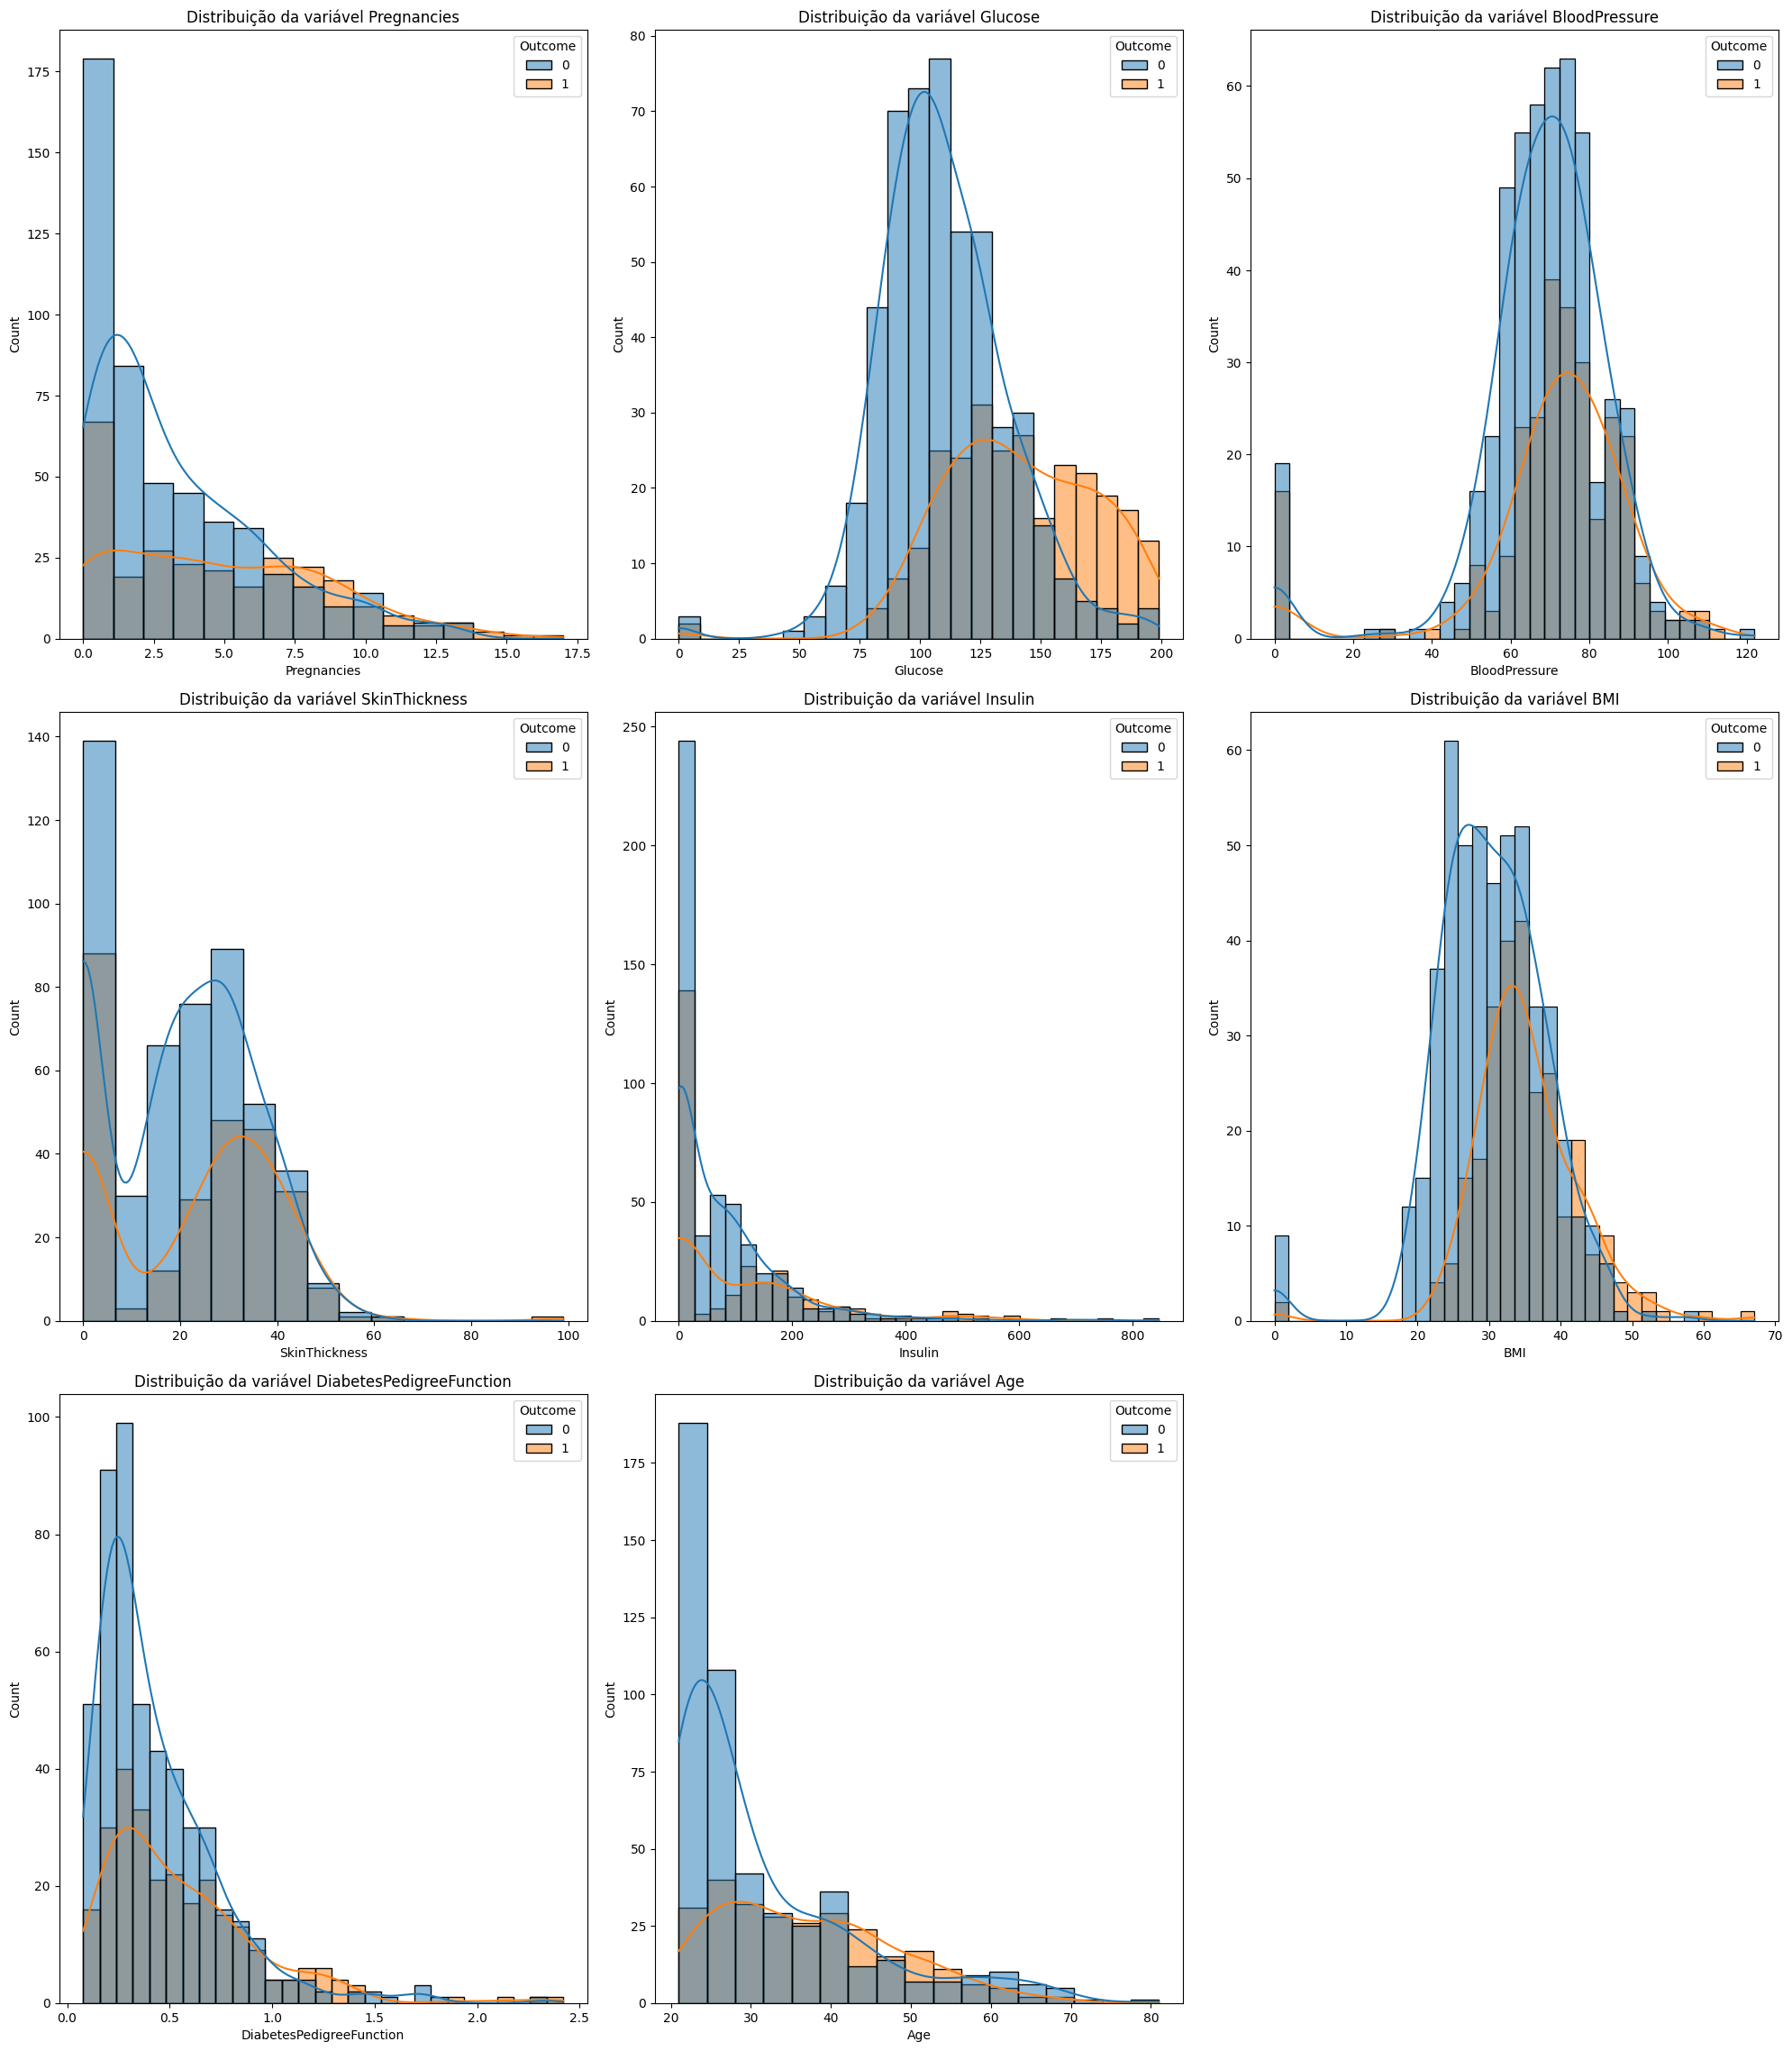

In [10]:
# Cria uma figura com grade de subplots
# converte o array 2D (4,3) do e um vetor 1D (12,) , facilitando iterar sobre os indices
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 30))
axes = axes.flatten()

for i, coluna in enumerate(X.columns):
    sns.histplot(data=X, x=coluna, kde=True, hue=y, ax=axes[i])
    axes[i].set_title(f"Distribuição da variável {coluna}")

# Remove subplots não utilizados (caso X tenha menos de nrows*ncols colunas)
for j in range(len(X.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(f'histogramas_{FILENAME}.png', dpi=150)
plt.show()

#### 3.2.2. AVALIAÇÃO DOS HISTOGRAMAS

Observando os histogramas gerados para cada variável em relação à presença de diabetes, podemos fazer as seguintes observações:

- **Glucose**, **BMI**, **DiabetesPedigreeFunction**, and **Age**: Essas variáveis apresentam diferenças perceptíveis nas distribuições entre as classes **Diabetic (1)** e **Non-diabetic (0)**. Por exemplo, indivíduos com diabetes tendem a apresentar valores maiores de Glucose, BMI e Age, e a DiabetesPedigreeFunction também costuma ser mais alta no grupo diabético. Essas variáveis parecem ser mais discriminativas entre as duas classes.

- **Pregnancies**, **BloodPressure**, **SkinThickness**, and **Insulin**: Essas variáveis mostram maior sobreposição nas distribuições entre as duas classes em comparação com as anteriores. Apesar de poder haver diferenças sutis na tendência central ou na dispersão, elas não separam tão claramente os grupos Diabetic e Non-diabetic.


#### 3.2.3. BOXPLOTS

É importante plotar os gráficos de Boxplots, pois resumem a distribuição de uma variável mostrando mediana, dispersão e outliers de forma visual e comparável entre grupos. Eles ajudam a detectar assimetria, variação e pontos extremos rapidamente, orientando pré-processamento, escolha de modelos e decisões sobre tratamento de outliers.

In [11]:
data.describe().round(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,120.895,69.105,20.536,79.799,31.993,0.472,33.241,0.349
std,3.370,31.973,19.356,15.952,115.244,7.884,0.331,11.760,0.477
min,0.000,0.000,0.000,0.000,0.000,0.000,0.078,21.000,0.000
25%,1.000,99.000,62.000,0.000,0.000,27.300,0.244,24.000,0.000
50%,3.000,117.000,72.000,23.000,30.500,32.000,0.372,29.000,0.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,41.000,1.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000,1.000


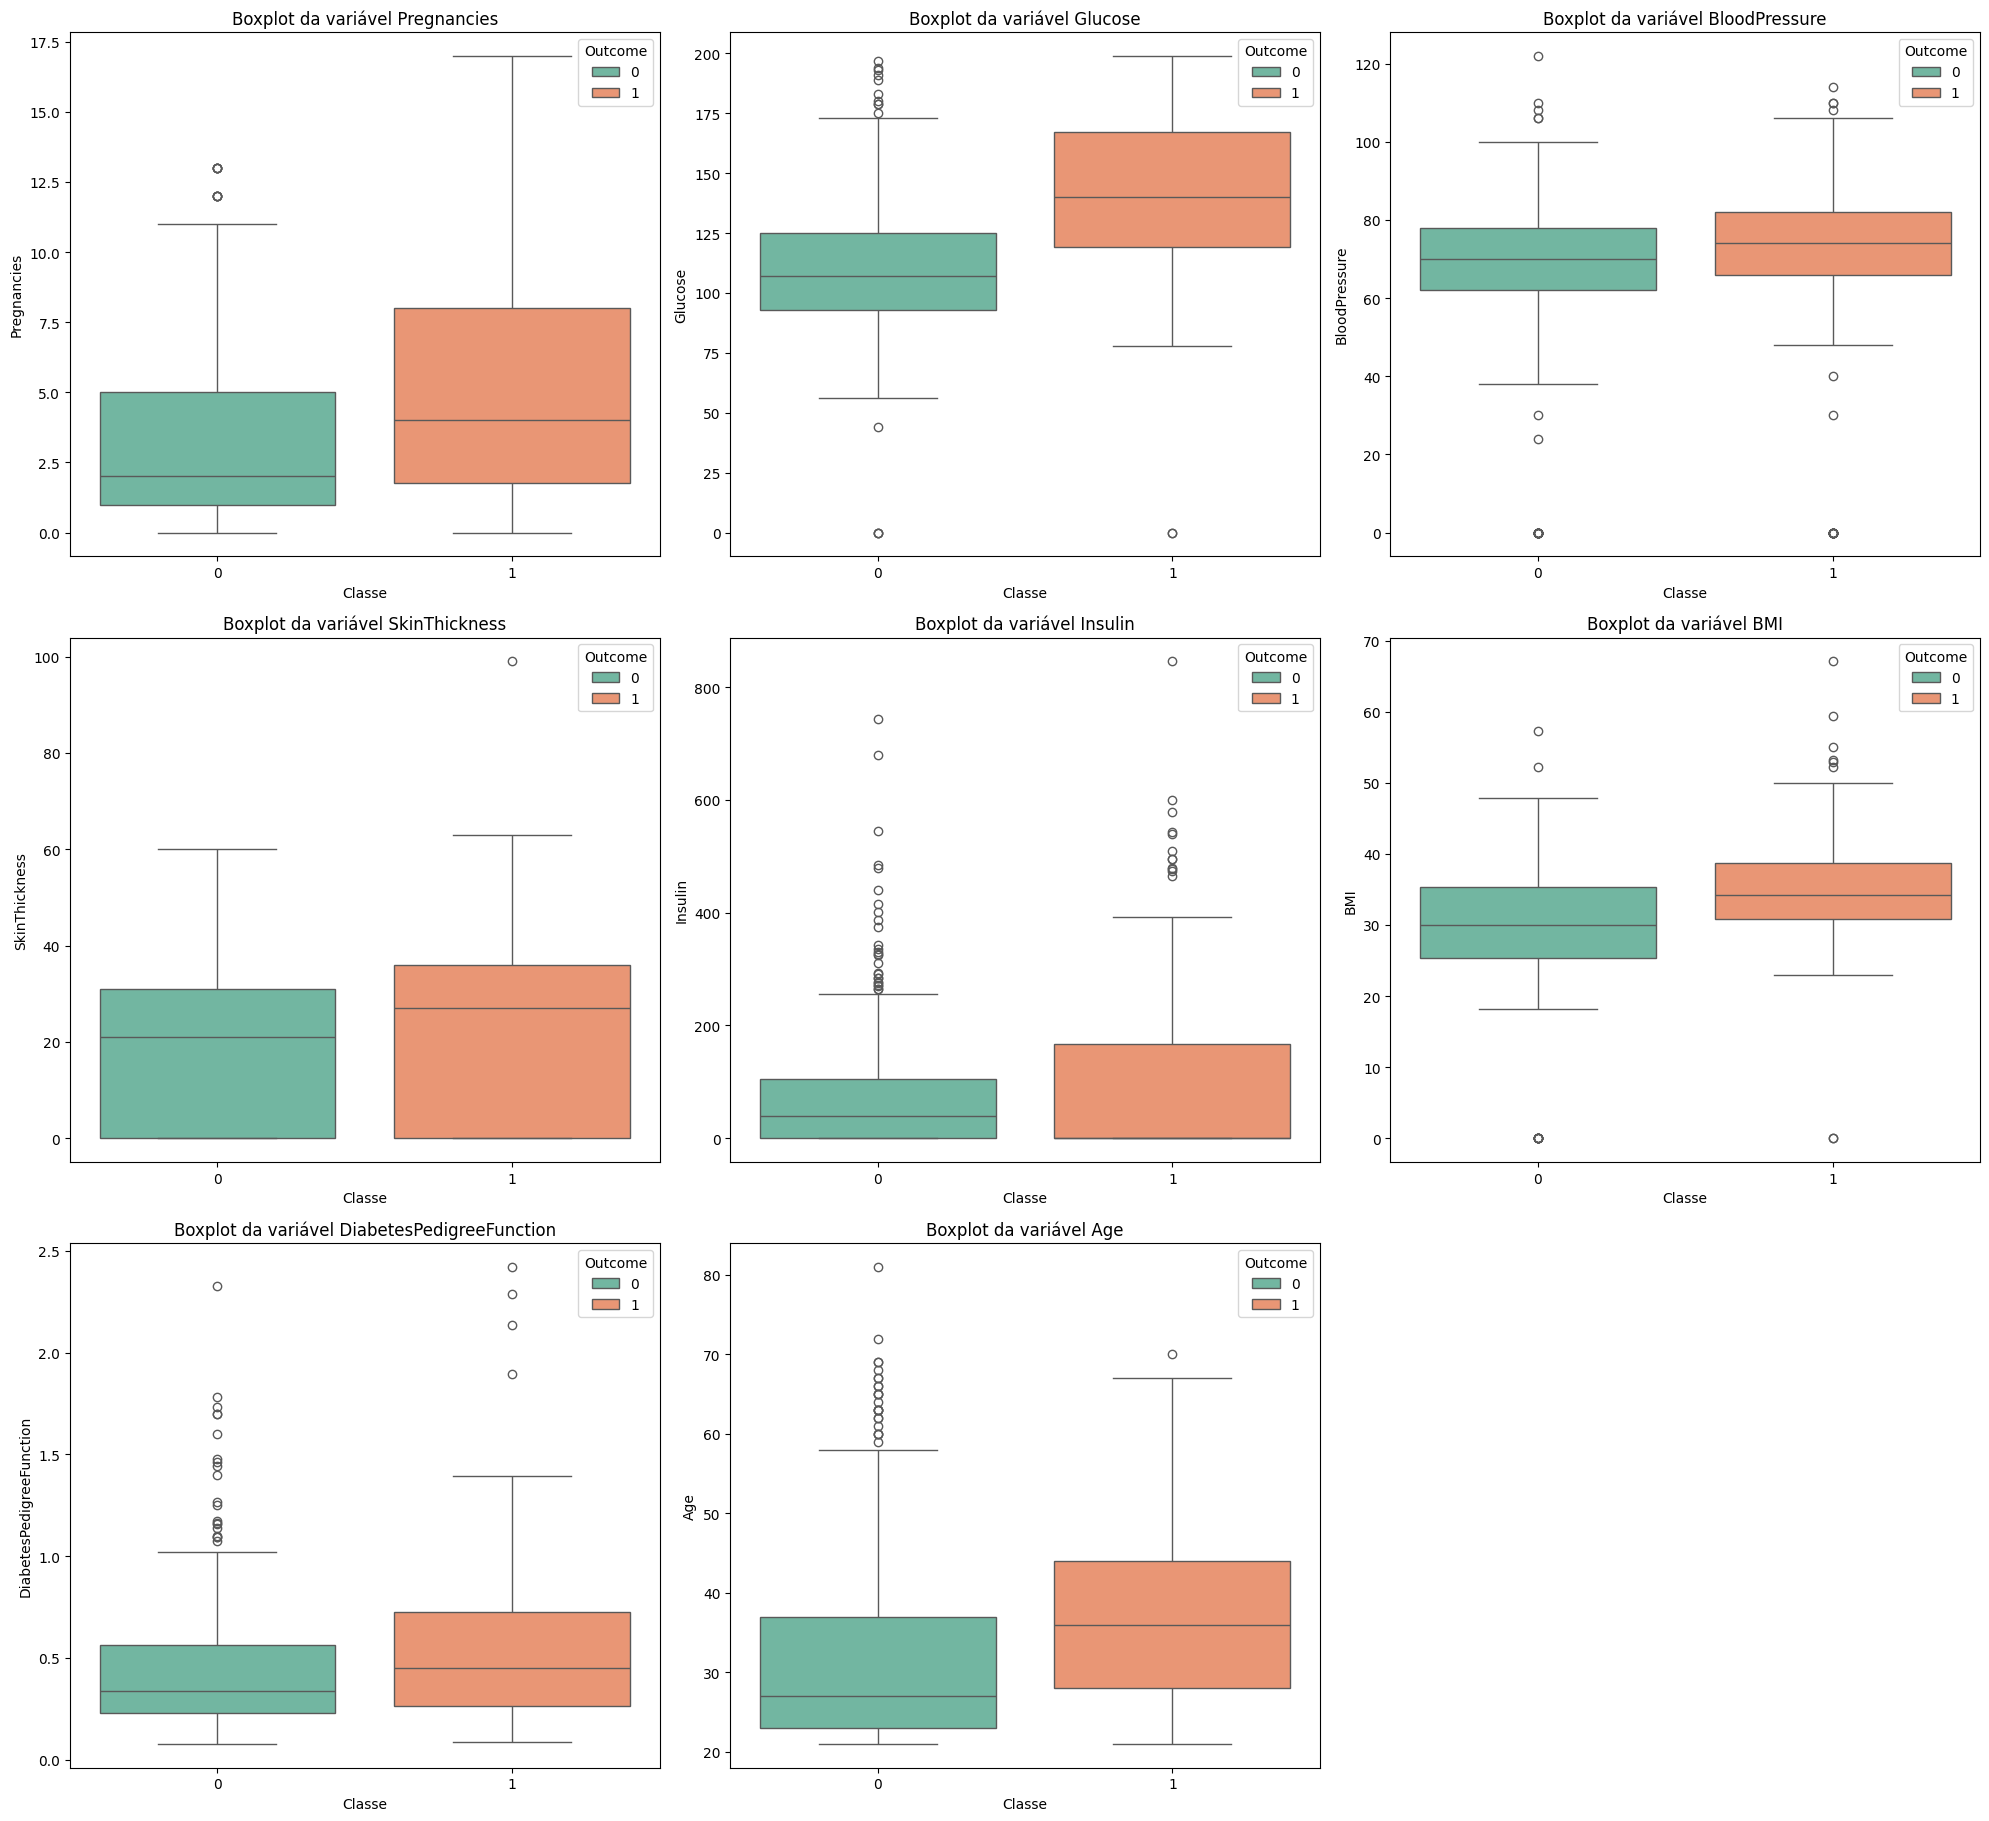

In [12]:
# Cria uma figura com grade de subplots
# converte o array 2D (4,3) do e um vetor 1D (12,) , facilitando iterar sobre os indices
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 30))
axes = axes.flatten()

for i, coluna in enumerate(X.columns):
    sns.boxplot(x=y, y=X[coluna], ax=axes[i], hue=y, palette="Set2")
    axes[i].set_title(f"Boxplot da variável {coluna}")
    axes[i].set_xlabel("Classe")
    axes[i].set_ylabel(coluna)

# Remove subplots não utilizados (caso X tenha menos de nrows*ncols colunas)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(f'boxplots_{FILENAME}.png', dpi=150)
plt.show()

# sns.boxplot(x=y, y=X['ph'], hue=y, palette='Set2')
# plt.title(f"Boxplot da variável ph")
# plt.xlabel('Classe')
# plt.ylabel('ph')
# plt.show()

### 3.2.4. AVALIAÇÃO DOS BOXPLOTS

Analisando os boxplots gerados para cada variável em relação à presença de diabetes, podemos observar o seguinte:

- **Glucose, BMI, DiabetesPedigreeFunction e Age:** Essas variáveis mostram diferenças mais claras na mediana e na distribuição entre as classes **Diabetic (1)** e **Non-diabetic (0)**. Os boxplots do grupo diabético tendem a apresentar medianas mais altas e, em alguns casos, maior dispersão para essas variáveis em comparação ao grupo não diabético, reforçando o que foi observado nos histogramas de que são mais discriminativas.

- **Pregnancies:** O boxplot indica que a mediana do número de gestações é ligeiramente maior no grupo diabético, com amplitude maior e alguns outliers com número muito elevado de gestações.

- **BloodPressure, SkinThickness e Insulin:** Essas variáveis apresentam grande sobreposição nos boxplots entre as duas classes. Apesar de poder haver diferenças nos valores máximos ou presença de outliers, a tendência central e os intervalos interquartis são bastante semelhantes, sugerindo menor capacidade discriminativa isolada. Além disso, **SkinThickness** e **Insulin** exibem muitas observações em zero, visíveis como concentração de pontos na base do boxplot, o que pode indicar valores ausentes codificados como zero ou problemas na coleta de dados.

De forma resumida, os boxplots corroboram que **Glucose, BMI, DiabetesPedigreeFunction e Age** são provavelmente as features mais informativas para separar indivíduos diabéticos de não diabéticos. **Pregnancies** apresenta diferença moderada. **BloodPressure, SkinThickness e Insulin** têm distribuições sobrepostas e potenciais problemas de qualidade (zeros, outliers) que exigem investigação e tratamento no pré-processamento.

#### 3.2.5. HEATMAP DAS CORRELAÇÕES ENTRE FEATURES

Vamos plotar um heatmap das features para visualizar padrões de correlação, identificar pares fortemente correlacionados e detectar redundâncias úteis para seleção ou engenharia de variáveis. Considerando duas variáveis distintas, temos que:

- Valores de correlação próximos de +1 indicam relação direta entre as variáveis, isto é, quando uma variável aumenta a outra aumenta também;
- Valores próximos de -1 indicam relação inversa, quando uma variável aumenta a outra diminui;
- Valores próximos de 0 indicam pouca ou nenhuma correlação.

Caso exista correlação forte, devemos fazer algum tipo de tratamento, como remoção da variável menos informativa, calcular média, soma, verificar se existe redundância, redução de dimnesionalidade PCA, etc.

<Axes: >

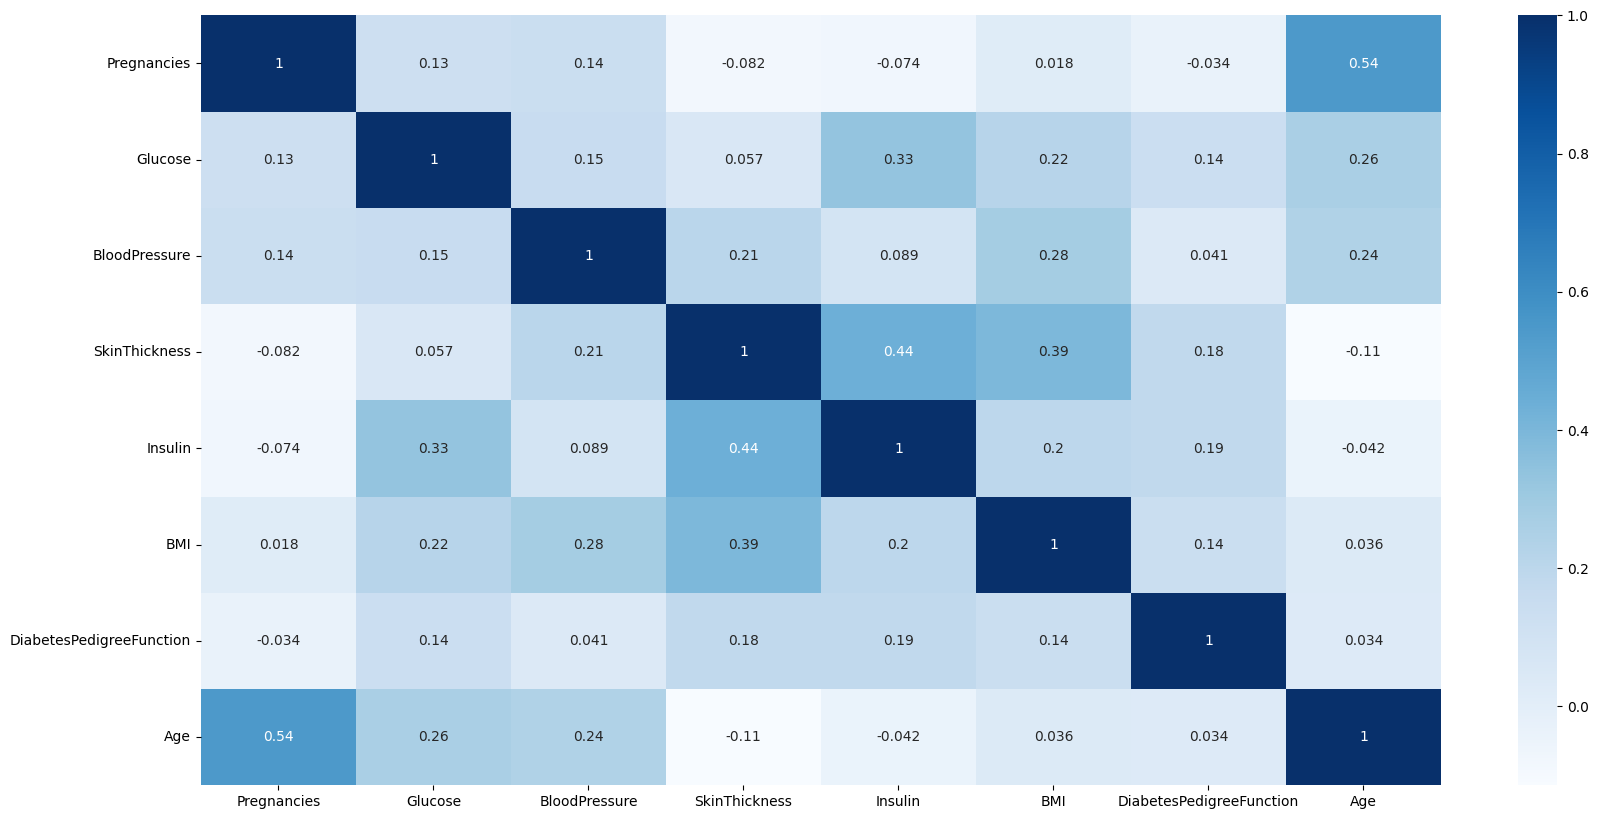

In [13]:
# Matriz de correlação
plt.figure(figsize=(20, 10))

sns.heatmap(X.corr(), annot=True, cmap="Blues")

### 3.2.6. AVALIAÇÃO DO HEATMAP

Nota-se que nenhuma variável apresenta alta correlação. Levemente moderada (por volta de 0.5) para Age e Pregnancies, mesmo assim, nada próximo de -1 ou de 1.Todas as outras relações estão próximas de zero.

#### 3.2.7 VERIFICAÇÃO DE DADOS AUSENTES

É importante verificar se existem dados ausentes (missing values). Caso existam, na etapa de pré-processamento precisamos fazer um tratamento adequado, seja ele remover registros que possuam valores ausentes ou aplicar imputation, isto é, preencher os valores ausentes com uma medida adequada, de acordo com o tipo de dado.

In [14]:
missing_count = data.isnull().sum().sort_values(ascending=False) # type(missing_count) pandas.core.series.Series

# o isnull retorna o data set com true false para a condicao is null, true = 1 false=0,
# desse modo, tirando a media dos valores 0 e 1, retorna a porcentagem, basta multiplicar por 100
missing_pct = (data.isnull().mean()*100).sort_values(ascending=False)

pd.concat([missing_count, missing_pct.round(2)], axis=1, keys=['count','percent'])


,count,percent
Pregnancies,0,0.0
Glucose,0,0.0
BloodPressure,0,0.0
SkinThickness,0,0.0
Insulin,0,0.0
BMI,0,0.0
DiabetesPedigreeFunction,0,0.0
Age,0,0.0
Outcome,0,0.0


Não existem valores ausentes. Todas as variáveis possuem valores. Portanto, não é necessário aplicar nenhuma técnica de imputação. Caso fosse necessário, recomenda-se fazer **imputation** usando a média ou mediana para variáveis numéricas, e moda para variáveis categóricas. Entre média e mediana, é comum utilizarem a mediana por ser robusta a outliers.

In [15]:
# Mostrando possíveis variáveis categóricas
cat_cols = data.select_dtypes(include=['object','category','bool']).columns.tolist()
cat_cols

[]

In [16]:
# Mostrando uma lista de todas as variáveis numéricas
num_cols = data.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

## 4. PRÉ-PROCESSAMENTO

### 4.1. TRATAMENTO DE DADOS AUSENTES

Conforme explicado no item anterior, não existem valores ausentes nos dados.Portanto, não é necessário fazer imputação. Mesmo assim, deixaremos aqui para caso esse notebook seja usado como base para outros datasets.
Na **Imputation**, preenchendo os valores ausentes com a **Mediana** para as colunas numéricas, por ser robusta a Outliers. Além disso, todas as variáveis do nosso dataset são numéricas.

In [17]:
# Todas as features são numericas, convertendo para array numpy para facilitar manipulação
# ['Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness' 'Insulin' 'BMI' 'DiabetesPedigreeFunction' 'Age']
num_features_cols = np.array(data.columns[:-1],dtype=str)
print('Features:\n', num_features_cols)

# Armazena o nome da variavel target, que desejamos prever
target_name = np.array(data.columns[-1],dtype=str) # Outcome => 1  = diabético, 0 = não-diabético
print('Target:',target_name)


Features:
 ['Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness' 'Insulin' 'BMI'
 'DiabetesPedigreeFunction' 'Age']
Target: Outcome


Limpeza de valores que tambem possam representar missing values, como ? ou espaços extras, padronizando para NaN.

In [18]:
data = data.copy() # É uma boa prática não alterar o dataframe original em memória
for c in data.select_dtypes(include=['object']).columns:
    data[c] = data[c].astype(str).str.strip().replace({'':np.nan, 'nan':np.nan,'?':np.nan})

# O param 'coerce' instrui o pandas a converter valores que não podem ser transformados em numéricos para NaN em vez de lançar um erro
for c in num_features_cols:
    data[c] = pd.to_numeric(data[c], errors='coerce')

# Análise de missing values antes da imputação
missing_count = data.isnull().sum().sort_values(ascending=False) # type(missing_count) pandas.core.series.Series
missing_pct = (data.isnull().mean()*100).sort_values(ascending=False)
pd.concat([missing_count, missing_pct.round(2)], axis=1, keys=['count','percent'])

,count,percent
Pregnancies,0,0.0
Glucose,0,0.0
BloodPressure,0,0.0
SkinThickness,0,0.0
Insulin,0,0.0
BMI,0,0.0
DiabetesPedigreeFunction,0,0.0
Age,0,0.0
Outcome,0,0.0


### 4.2. NORMALIZAÇÃO DAS VARIÁVEIS NUMÉRICAS

Ao aplica ro método **describe()**, podemos notar que o intervalo das variáveis numéricas varia bastante.  Executa-se a seguir mais uma vez o comando. Observe os valores máxims e mínimos. Variáveis com 2, 3, até 5 digitos.

In [19]:
data.describe().round(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24,0.35
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00,0.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


É importante **Normalizar** as variáveis. Dessa forma, todas as variáveis numéricas ficam com valores na mesma ordem de magnitude. Isso garante que cada uma contribua de forma equilibrada para, evitando que features com escala maior dominem o aprendizado.

Dentre os métodos de normalização, usaremos a padronização **z-score**, que subtrai a média e divide pelo desvio padrão, para centrar os dados em zero com variância unitária. Após aplicar esse método, a média dos dados passa a ser zero e o desvio padrão igual a 1.

### 4.3. PREPARAÇÃO DOS TRANSFORMADORES PARA PRÉ-PROCESSAMENTO

Para evitar vazamento de dados, **data leakage**, a imputação (imputation) e a padronização na escala são feitos dentro de um pipeline que será fitado apenas no conjunto de treino. Além disso, facilita experimentação e reprodução, tendo em vista que é gerado um objeto único que pode ser salvo/carregado.
A pipeline a seguir define os passos de imputação e padronização.

In [20]:
# Imputation de mediana por ser resistente  a outliers para variaveis numericas e moda (mais frequente)
# para variaveis categoricas
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent') # nao vamos precisar desse, pois nao têm dados categoricos

# Pipeline numerico: imputação mediana  por ser mais robusto a outliers,
# seguida de normalização cada feature x em (x - mean) / std
num_pipeline = Pipeline(
    steps=[
        ('imputer', num_imputer),
        ('scaler', StandardScaler())
    ]
)


O **ColumnTransformer** aplica pipelines diferentes às colunas especificadas e concatena os resultados em uma única matriz pronta para o modelo. No caso específico desse dataset não temos colunas categóricas, apenas numéricas, então não é obrigatório o uso do ColumnTransformer, pois temos apenas uma pipeline. No entanto, como é uma boa prática, foi mantido.

In [21]:
# ColumnTransformer aplica pipelines às colunas corretas e concatena resultados
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_features_cols)
], remainder='drop')  # "drop" garante que apenas as colunas listadas sejam processadas

### 4.4. APLICAR PRÉ-PROCESSAMENTO AOS DADOS

In [22]:
# Separar as X e y antes de transformar, o que é uma boa prática para evitar vazamento
X = data[num_features_cols]
y = data[target_name].copy() # manter a versao original do rotulo/target para manter documentacao


# Aplicar a pipeline de pré-processamento nas features
X_preprocessed = preprocessor.fit_transform(X)
X_preprocessed

array([[ 0.63994726,  0.84832379,  0.14964075, ...,  0.20401277,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.12339636, -0.16054575, ..., -0.68442195,
        -0.36506078, -0.19067191],
       [ 1.23388019,  1.94372388, -0.26394125, ..., -1.10325546,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 ,  0.00330087,  0.14964075, ..., -0.73518964,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.1597866 , -0.47073225, ..., -0.24020459,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.8730192 ,  0.04624525, ..., -0.20212881,
        -0.47378505, -0.87137393]], shape=(768, 8))

In [23]:
# Observando as estatísticas das features pré-processadas
pd.DataFrame(X_preprocessed).describe().round(3)

,0,1,2,3,4,5,6,7
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000
std,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001
min,-1.142,-3.784,-3.573,-1.288,-0.693,-4.060,-1.190,-1.042
25%,-0.845,-0.685,-0.367,-1.288,-0.693,-0.596,-0.689,-0.786
50%,-0.251,-0.122,0.150,0.155,-0.428,0.001,-0.300,-0.361
75%,0.640,0.606,0.563,0.719,0.412,0.585,0.466,0.660
max,3.907,2.444,2.735,4.922,6.653,4.456,5.884,4.064


In [24]:
# As colunas numericas estao em escala com media zero e desvio padrao 1, vamos renomear as colunas
num_scaled_cols = [f"{c}_scaled" for c in num_features_cols]
output_cols = num_scaled_cols
output_cols

['Pregnancies_scaled',
 'Glucose_scaled',
 'BloodPressure_scaled',
 'SkinThickness_scaled',
 'Insulin_scaled',
 'BMI_scaled',
 'DiabetesPedigreeFunction_scaled',
 'Age_scaled']

In [25]:
data_preprocessed = pd.DataFrame(X_preprocessed, columns=output_cols, index=data.index)
display(data_preprocessed.head())

,Pregnancies_scaled,Glucose_scaled,BloodPressure_scaled,SkinThickness_scaled,Insulin_scaled,BMI_scaled,DiabetesPedigreeFunction_scaled,Age_scaled
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496


### 4.5. VERIFICAÇÃO QUE NÃO EXISTEM MAIS MISSING VALUES

In [26]:
# Análise de missing values depois do pré-processamento
print("\nValores faltantes após preprocessamento/imputacao:")
missing_count = data_preprocessed.isnull().sum().sort_values(ascending=False) # type(missing_count) pandas.core.series.Series
pd.concat([missing_count], axis=1, keys=['count'])


Valores faltantes após preprocessamento/imputacao:


,count
Pregnancies_scaled,0
Glucose_scaled,0
BloodPressure_scaled,0
SkinThickness_scaled,0
Insulin_scaled,0
BMI_scaled,0
DiabetesPedigreeFunction_scaled,0
Age_scaled,0


### 4.6. SALVAR O PRÉ-PROCESSADOR DE TRANSFORMACÃO

É importante salvar o pré-processador (ColumnTransformer), conservando informação sobre a transformação aplicada. Isso é importante principalmente para reutilização e uso em produção.

O comando a seguir serializa e grava em disco um objeto Python em formato eficiente para carregamento posterior, preservando o estado interno necessário para transformações ou mapeamentos.

In [27]:
# Conservar informação sobre a transformação aplicada (importante para produção)
# Salvar o preprocessor para reutilização
joblib.dump(preprocessor, "preprocessor.joblib")  # objeto ColumnTransforme

['preprocessor.joblib']

4.7. DISTRIBUIÇÃO DAS CLASSES

In [28]:
# Balanceamento entre as classes # Outcome => 1  = diabético, 0 = não-diabético
data[target_name].value_counts(normalize=True).round(2)*100

target_name_count = data[target_name].value_counts()
target_name_pct = data[target_name].value_counts(normalize=True).round(2)*100
pd.concat([target_name_count, target_name_pct.round(2)], axis=1, keys=['count','percent(%)'])


,count,percent(%)
Outcome,,
0,500,65.0
1,268,35.0


Nota-se que existe desbalanceamento de classes, onde **35%** dos dados são rotulados como **Diabético (1)**. Em contrapartida, a maioria dos registros, 65%, são classificados como **Não diabético (0)**. Posteriormente, durante o pré-processamento precisaremos aplicar alguma técnica para balancear as classes.


### 4.8. ANÁLISE DE COMPONENTES PRINCIPAIS

A **Análise de Componentes Principais** ou **Principal Component Analysis (PCA)**, em inglês, é uma técnica de redução de dimensionalidade que transforma features originais em novas variáveis ortogonais chamadas **Componentes**, ordenadas pela quantidade de variância que explicam. Serve para condensar informação de muitas variáveis correlacionadas em menos dimensões, facilitar visualização e reduzir ruído sem supervisionamento.
No caso dos nosso dados, não existe uma correlação forte, mesmo assim, faremos essa análise.

O PCA é sensível a escala das features, por isso é importante utilizar a versão padronizada dos dados, assegurando que features com grandes valores não dominem como componentes principais.
Atualmente, temos 8 features.


In [29]:
# Aplicar PCA para reduzir dimensionalidade e condensar informação redundante
pca = PCA(n_components=0.98)  # Manter componentes que explicam 98% da variância total

# Transformar dados escalados para o espaço dos componentes principais
X_pca = pca.fit_transform(X_preprocessed)  # Fit aprende os loadings; transform projeta X_preprocessed nos PCs

display(X_pca.shape[1])

8

PCA transforma features originais em combinações lineares chamadas **Componentes**, o que reduz interpretabilidade direta das variáveis originais Ainda assim, PCA contribui para explicabilidade quando se analisa **Loadings** (coeficientes) para entender quais features mais influenciam cada componente, permitindo interpretar componentes em termos das features originais.

Após o pca, não houve redução na dimensionalidade. Precisamos de 8 componentes para explicar 98% da variabilidade.

<Axes: >

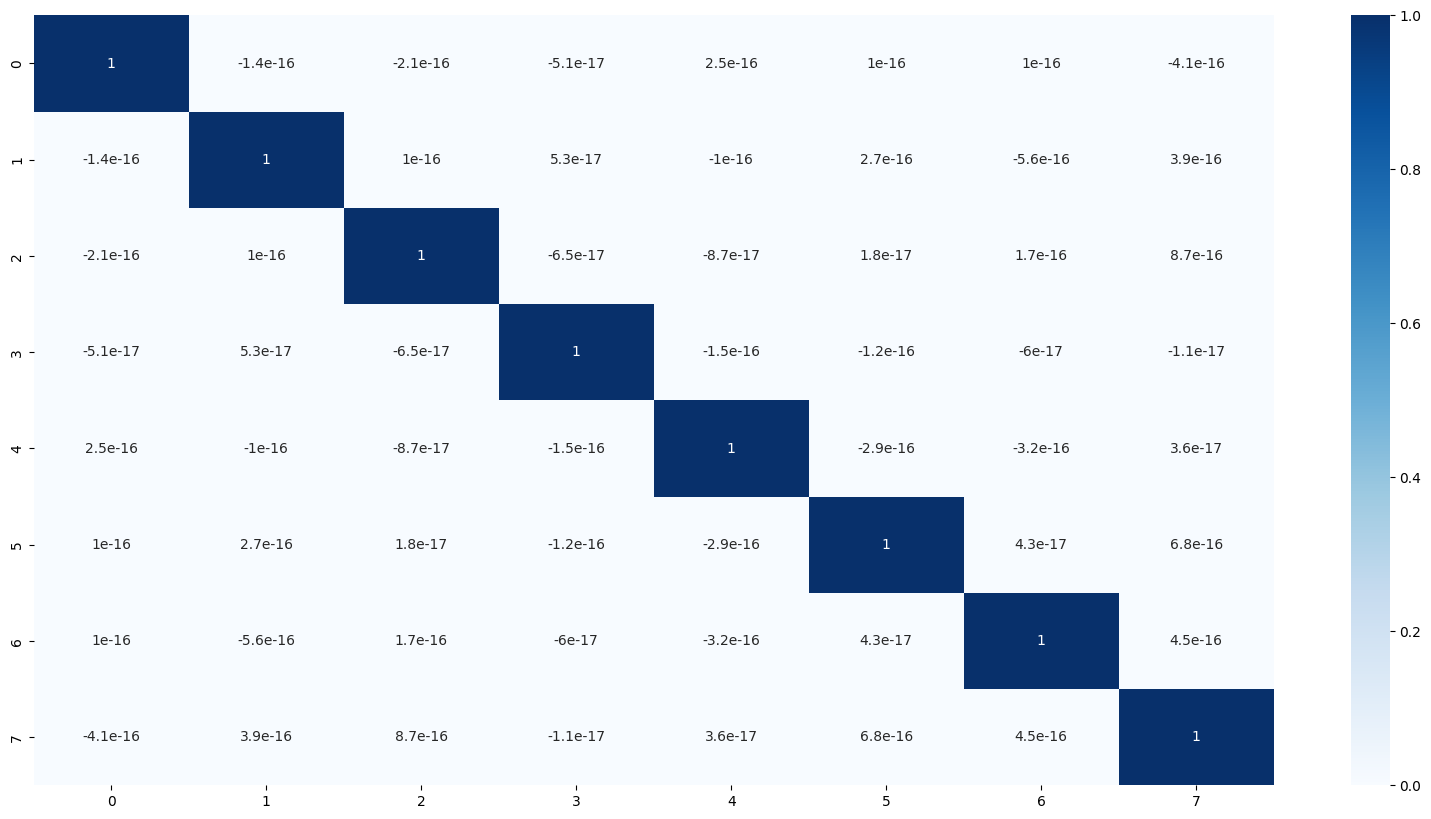

In [30]:
# Matriz de correlação dos componentes principais
plt.figure(figsize=(20, 10))
sns.heatmap(pd.DataFrame(X_pca).corr(), annot=True, cmap="Blues")

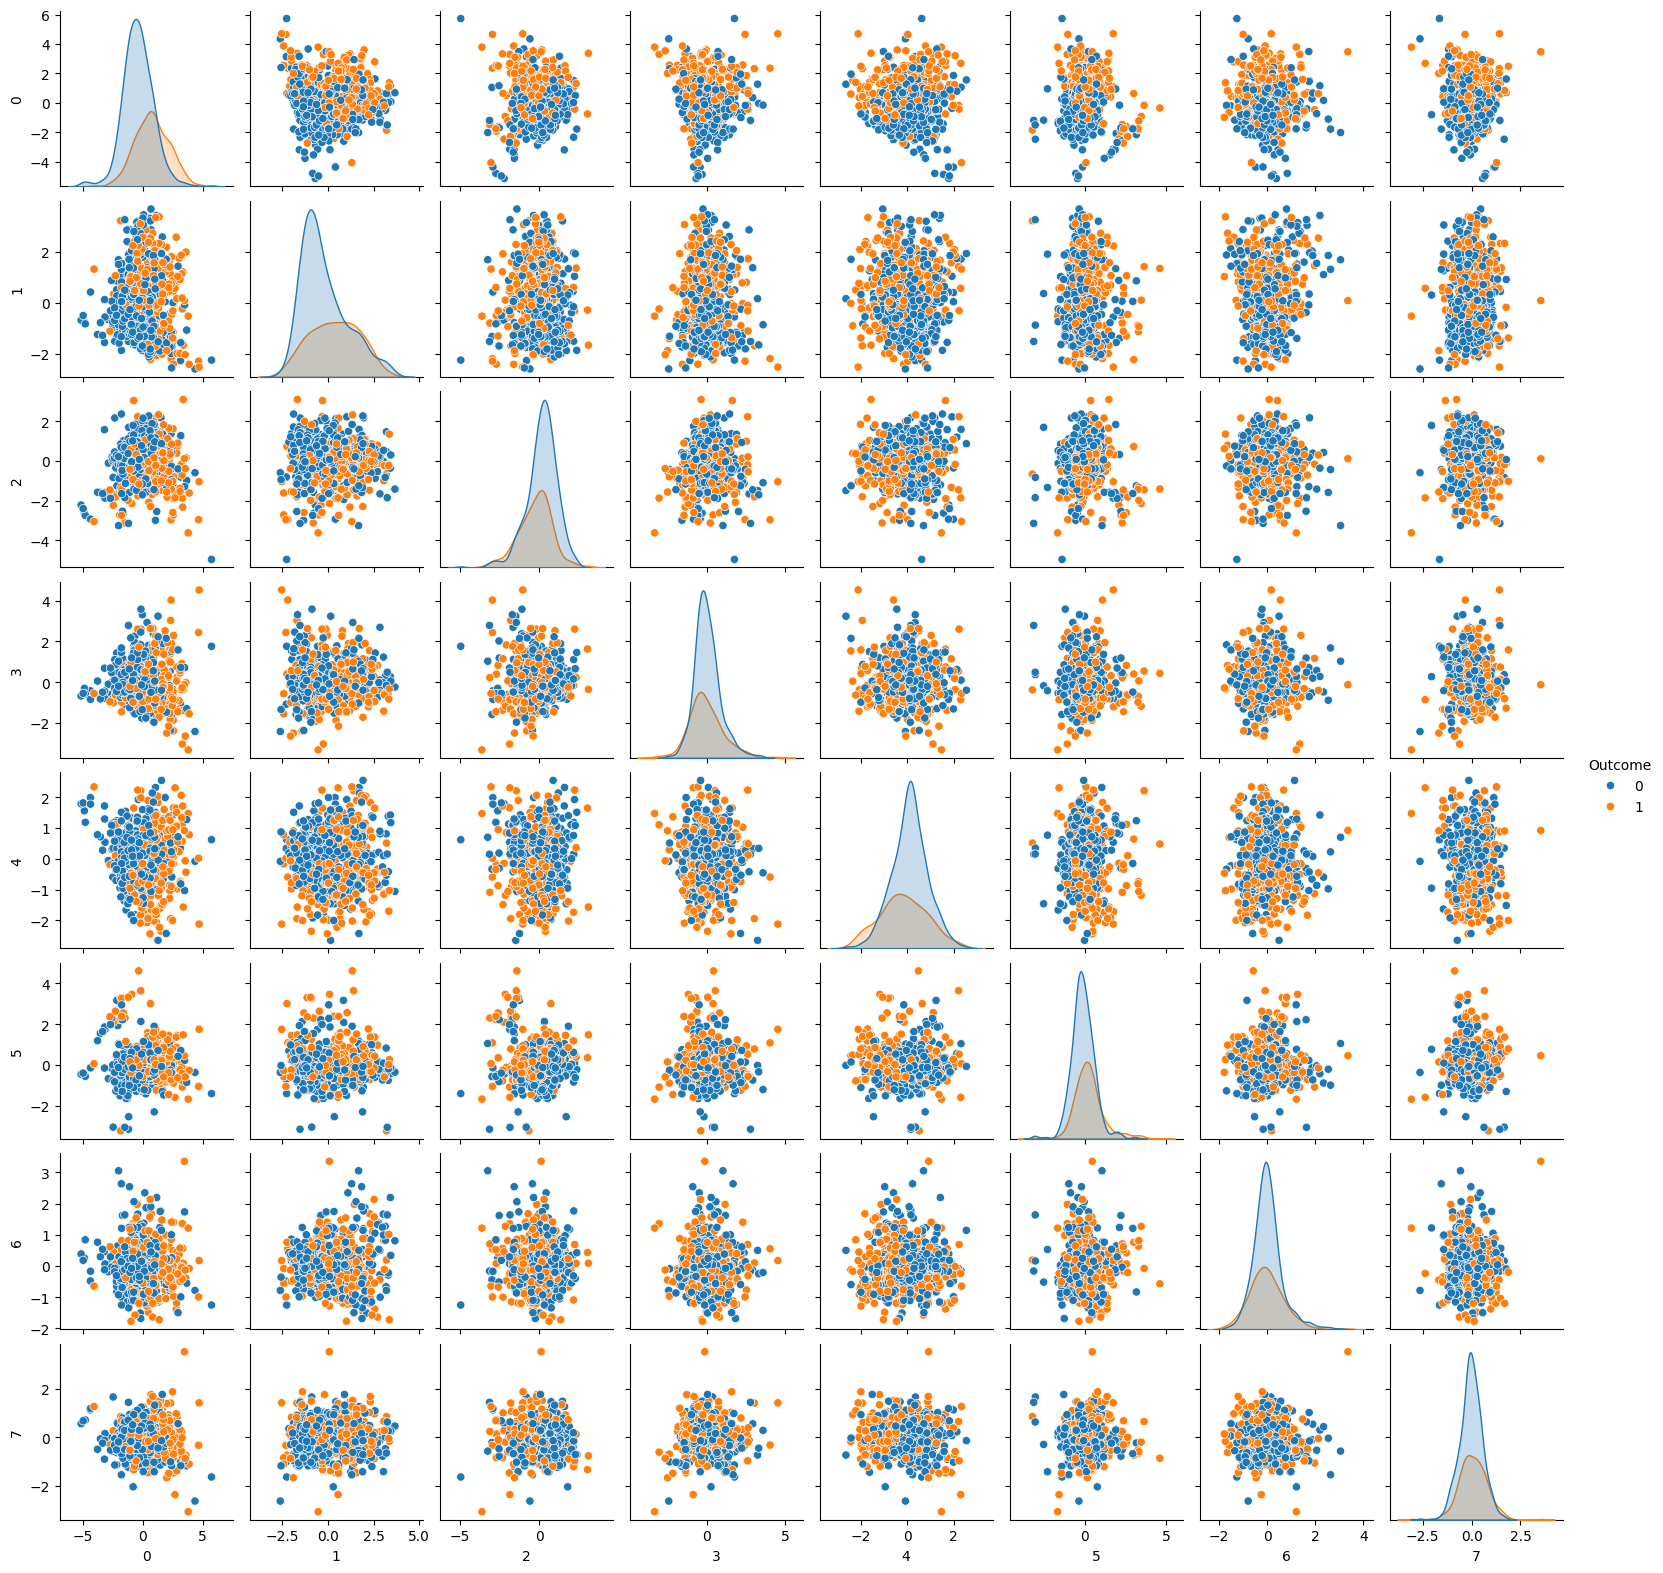

In [31]:
# imprimindo o pairPlot (gráfico de dispersão) após o redução de dimensões

data_pca = pd.DataFrame(X_pca)

# para acessar o valor de taget name  usa [()] pq esse caso específico nao tem dimensão
data_pca[target_name[()]] = y

# data_pca.shape
# y.to_numpy()

# df_pca.head()

sns.pairplot(data=pd.DataFrame(data_pca), hue=target_name[()], height=2, aspect=1)

#### 4.8.1. AVALIAÇÃO DO PAIRPLOT

Analisando o pairplot dos componentes principais coloridos pela presença de diabetes (Outcome), observamos que:

*   Não há uma separação linear clara entre as classes **Diabético (1)** e **Não diabético (0)** em nenhum dos pares de componentes principais visualizados. As distribuições das duas classes se sobrepõem consideravelmente em todas as projeções 2D.
*   Apesar da sobreposição, alguns pares de componentes mostram tendências onde uma classe é mais concentrada em certas regiões, o que sugere que combinações lineares das features originais (representadas pelos componentes principais) capturam alguma informação relevante para a distinção entre as classes, embora não o suficiente para uma separação completa e fácil visualização em 2D.
*   A maior separação visual, embora ainda com muita sobreposição, parece ocorrer em pares de componentes que são mais influenciados pelas variáveis identificadas anteriormente como mais discriminativas (Glucose, BMI, DiabetesPedigreeFunction, Age).

Isso sugere que, mesmo no espaço reduzido pelos componentes principais, as classes não são facilmente distinguíveis por limites lineares simples. A classificação provavelmente exigirá modelos mais complexos que possam capturar interações não lineares entre os componentes ou que trabalhem de forma eficaz em um espaço de maior dimensionalidade ou com as features originais transformadas. A análise corrobora a necessidade de modelos de classificação robustos e, possivelmente, técnicas de balanceamento de classes devido à distribuição desigual.

## 5. Treinamento, Validação e Teste (Modelo: Knn, Árvores de Decisão, Random Forest, SVM, XBoost, LightGBM, Bayesiano etc)

### 5.1. SPLIT DOS DADOS EM CONJUNTO DE TREINO E TESTE

Separar os dados em treino e teste evita vazamento de informação (data leakage), garantindo que a avaliação reflita desempenho em dados não vistos. Isso permite estimar generalização do modelo e detectar overfitting antes do deploy.

In [32]:
# Os dados tratados são divididos em teste e treino stratify=y
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, stratify=y, random_state=42)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])


Training set size: 614
Testing set size: 154


### 5.2. TREINAMENTO E VALIDAÇÃO (CROSS VALIDATION)

In [33]:
# X_preprocessed, y já definidos (X_preprocessed: features prontos para o modelo)
# Diretório de saída
OUT_DIR = "models_output"
os.makedirs(OUT_DIR, exist_ok=True)

In [34]:
# Instanciar modelos com hiperparâmetros básicos (ajuste com CV/opt é recomendado)
base_models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "SVM": SVC(probability=True, kernel='rbf', C=1.0, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1),
    "LightGBM": lgb.LGBMClassifier(random_state=42, n_jobs=-1),
    "GaussianNB": GaussianNB()
}

In [35]:
# Scorers para o cross validation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
}

In [36]:
# Instanciando o Cross validation com 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [37]:
# Dicionário para armazenar resultados sumarizados
results = {}
summary_rows = []

# Aplica SMOTE para os dados de treinamento, balanceando as classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

for name, estimator in base_models.items():
    # Pipeline de preprocessamento foi aplicado anteriormente
    pipe = Pipeline([
        ('clf', estimator)
    ])

    start = time.time()
    # Aplica cross_validate nos dados reamostrados
    cv_res = cross_validate(pipe, X_train_resampled, y_train_resampled, cv=cv, scoring=scoring,
                            return_train_score=False, n_jobs=-1)
    elapsed = time.time() - start

    # Resumo estatístico das métricas por fold
    metrics_summary = {m: {"mean": float(np.mean(cv_res[f'test_{m}'])),
                          "std": float(np.std(cv_res[f'test_{m}']))}
                       for m in scoring.keys()}

    # Treina pipeline final nos dados reamostrados e avalia usando dado de teste
    pipe.fit(X_train_resampled, y_train_resampled)  # Fit on resampled data
    y_test_pred = pipe.predict(X_test)

    # Para a metrica roc_auc no dado de teste, usa predict_proba quando disponivel
    try:
        y_test_proba = pipe.predict_proba(X_test)[:, 1]
        test_roc = roc_auc_score(y_test, y_test_proba)
    except Exception:
        # Usa decision_function quando disponivel
        try:
            y_scores = pipe.decision_function(X_test)
            test_roc = roc_auc_score(y_test, y_scores)
        except Exception:
            test_roc = np.nan


    # Calcular métricas no conjunto de teste
    test_metrics = {
        "accuracy": float(accuracy_score(y_test, y_test_pred)),
        "precision": float(precision_score(y_test, y_test_pred, zero_division=0)),
        "recall": float(recall_score(y_test, y_test_pred, zero_division=0)),
        "f1": float(f1_score(y_test, y_test_pred, zero_division=0)),
        "roc_auc": float(test_roc)
    }

    # Salvar modelo final e resumir resultados
    model_path = os.path.join(OUT_DIR, f"{name}_pipeline.joblib")
    dump(pipe, model_path)

    entry = {
        "cv_metrics": metrics_summary,
        "cv_fit_time_mean": float(np.mean(cv_res['fit_time'])),
        "cv_score_time_mean": float(np.mean(cv_res['score_time'])),
        "cv_elapsed": elapsed,
        "test_metrics": test_metrics,
        "model_path": model_path,
        "cv_raw": {k: v.tolist() for k, v in cv_res.items()}
    }
    results[name] = entry

    summary_rows.append({
        "model": name,
        "cv_accuracy_mean": metrics_summary['accuracy']['mean'],
        "cv_accuracy_std": metrics_summary['accuracy']['std'],
        "cv_f1_mean": metrics_summary['f1']['mean'],
        "test_accuracy": test_metrics['accuracy'],
        "test_f1": test_metrics['f1'],
        "test_roc_auc": test_metrics['roc_auc']
    })

# Salvar resultados completos
dump(results, os.path.join(OUT_DIR, "cv_results_with_smote.joblib"))
pd.DataFrame(summary_rows).sort_values(by='cv_f1_mean', ascending=False).to_csv(os.path.join(OUT_DIR, "cv_summary_with_smote.csv"), index=False)


# Mostrar resumo no notebook com pandas DataFrame
summary_df = pd.DataFrame(summary_rows).sort_values(by='cv_f1_mean', ascending=False)
display(summary_df)   # Jupyter: exibe tabela com métricas resumidas

,model,cv_accuracy_mean,cv_accuracy_std,cv_f1_mean,test_accuracy,test_f1,test_roc_auc
2,RandomForest,0.81375,0.007289,0.817406,0.727273,0.631579,0.818796
5,LightGBM,0.80500,0.009186,0.808191,0.766234,0.689655,0.820185
4,XGBoost,0.80000,0.012500,0.805960,0.740260,0.642857,0.803889
0,KNN,0.78250,0.028062,0.795860,0.675325,0.603175,0.704537
3,SVM,0.77625,0.023519,0.783967,0.714286,0.656250,0.790000
1,DecisionTree,0.74750,0.016105,0.748061,0.675325,0.561404,0.656296
6,GaussianNB,0.74750,0.027272,0.732399,0.720779,0.644628,0.783148


## 6. OTIMIZAÇÃO DE MODELOS (FINE TUNING)

Vamos utilizar o GridSearchCV para encontrar os melhores hiperparâmetros para cada modelo.

In [38]:
# Versão com grid e fining tuning para determinar melhores hiperparâmetros
# Dicionário para armazenar resultados sumarizados
results_tuned = {}
summary_rows_tuned = []

# Aplicar SMOTE para balancear as classes, aumentando a classe minoritaria
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

X_train_resampled_df = pd.DataFrame(X_train_resampled)
y_train_resampled_series = pd.Series(y_train_resampled, name=target_name[()])

# Definir grid de parametros para cada modelo
param_grids = {
    "KNN": {'clf__n_neighbors': [3, 5, 7, 9]},
    "DecisionTree": {'clf__max_depth': [None, 10, 20, 30], 'clf__min_samples_split': [2, 5, 10]},
    "RandomForest": {'clf__n_estimators': [100, 200, 300, 400], 'clf__max_depth': [None, 10, 20], 'clf__min_samples_split': [2, 5, 8]},
    "SVM": {'clf__C': [0.1, 1, 10], 'clf__kernel': ['rbf', 'linear']},
    "XGBoost": {'clf__n_estimators': [100, 200, 300, 400], 'clf__learning_rate': [0.01, 0.1, 0.2], 'clf__max_depth': [3, 5, 7, 9]},
    "LightGBM": {'clf__n_estimators': [100, 200, 300, 400], 'clf__learning_rate': [0.01, 0.1, 0.2], 'clf__max_depth': [3, 5, 7, 9]},
}

# Usar 'f1' como métrica de pontuacao do GridSearchCV
grid_scoring = make_scorer(f1_score, zero_division=0)

for name, estimator in base_models.items():
    print(f"Tuning {name}...")
    pipe = Pipeline([
        ('clf', estimator)
    ])

    # Usa grid de parametros do modelo atual
    param_grid = param_grids.get(name, {})

    grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring=grid_scoring, n_jobs=-1)

    start = time.time()
    grid_search.fit(X_train_resampled_df, y_train_resampled_series)
    elapsed = time.time() - start

    best_estimator = grid_search.best_estimator_
    y_test_pred = best_estimator.predict(X_test)

    try:
        y_test_proba = best_estimator.predict_proba(X_test)[:, 1]
        test_roc = roc_auc_score(y_test, y_test_proba)
    except Exception:
          try:
            y_scores = best_estimator.decision_function(X_test)
            test_roc = roc_auc_score(y_test, y_scores)
          except Exception:
            test_roc = np.nan


    test_metrics = {
        "accuracy": float(accuracy_score(y_test, y_test_pred)),
        "precision": float(precision_score(y_test, y_test_pred, zero_division=0)),
        "recall": float(recall_score(y_test, y_test_pred, zero_division=0)),
        "f1": float(f1_score(y_test, y_test_pred, zero_division=0)),
        "roc_auc": float(test_roc)
    }

    # Salvar o melhor modelo encontrado pelo GridSearchCV
    model_path = os.path.join(OUT_DIR, f"{name}_pipeline_tuned.joblib")
    dump(best_estimator, model_path)

    entry = {
        "best_params": grid_search.best_params_,
        "cv_best_score": float(grid_search.best_score_),
        "test_metrics": test_metrics,
        "model_path": model_path,
        "tuning_elapsed": elapsed,
    }
    results_tuned[name] = entry

    summary_rows_tuned.append({
        "model": name,
        "tuning_method": "GridSearchCV",
        "best_params": str(grid_search.best_params_),
        "cv_best_f1": float(grid_search.best_score_),
        "test_accuracy": test_metrics['accuracy'],
        "test_f1": test_metrics['f1'],
        "test_roc_auc": test_metrics['roc_auc']
    })

# Salvar resultados completos da otimização
dump(results_tuned, os.path.join(OUT_DIR, "cv_gridsearch_results_with_smote.joblib"))
pd.DataFrame(summary_rows_tuned).sort_values(by='cv_best_f1', ascending=False).to_csv(os.path.join(OUT_DIR, "cv_gridsearch_summary_with_smote.csv"), index=False)

# Mostrar resumo no notebook (pandas DataFrame)
summary_df_tuned = pd.DataFrame(summary_rows_tuned).sort_values(by='cv_best_f1', ascending=False)
display(summary_df_tuned)

Tuning KNN...
Tuning DecisionTree...
Tuning RandomForest...
Tuning SVM...
Tuning XGBoost...
Tuning LightGBM...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Tuning GaussianNB...


,model,tuning_method,best_params,cv_best_f1,test_accuracy,test_f1,test_roc_auc
2,RandomForest,GridSearchCV,"{'clf__max_depth': None, 'clf__min_samples_spl...",0.825730,0.746753,0.666667,0.819074
3,SVM,GridSearchCV,"{'clf__C': 10, 'clf__kernel': 'rbf'}",0.816922,0.688312,0.586207,0.776111
0,KNN,GridSearchCV,{'clf__n_neighbors': 3},0.815094,0.649351,0.557377,0.693704
5,LightGBM,GridSearchCV,"{'clf__learning_rate': 0.2, 'clf__max_depth': ...",0.809728,0.753247,0.660714,0.798704
4,XGBoost,GridSearchCV,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.809296,0.759740,0.678261,0.824815
1,DecisionTree,GridSearchCV,"{'clf__max_depth': None, 'clf__min_samples_spl...",0.748061,0.675325,0.561404,0.656296
6,GaussianNB,GridSearchCV,{},0.732399,0.720779,0.644628,0.783148


In [39]:
# Visualização completa de cada modelo e suas métricas em treino e teste
display(summary_rows_tuned)
display(summary_df_tuned)

[{'model': 'KNN',
  'tuning_method': 'GridSearchCV',
  'best_params': "{'clf__n_neighbors': 3}",
  'cv_best_f1': 0.8150938169247025,
  'test_accuracy': 0.6493506493506493,
  'test_f1': 0.5573770491803278,
  'test_roc_auc': 0.6937037037037037},
 {'model': 'DecisionTree',
  'tuning_method': 'GridSearchCV',
  'best_params': "{'clf__max_depth': None, 'clf__min_samples_split': 2}",
  'cv_best_f1': 0.7480605557094064,
  'test_accuracy': 0.6753246753246753,
  'test_f1': 0.5614035087719298,
  'test_roc_auc': 0.6562962962962962},
 {'model': 'RandomForest',
  'tuning_method': 'GridSearchCV',
  'best_params': "{'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 400}",
  'cv_best_f1': 0.8257297341900844,
  'test_accuracy': 0.7467532467532467,
  'test_f1': 0.6666666666666666,
  'test_roc_auc': 0.8190740740740741},
 {'model': 'SVM',
  'tuning_method': 'GridSearchCV',
  'best_params': "{'clf__C': 10, 'clf__kernel': 'rbf'}",
  'cv_best_f1': 0.8169215989951187,
  'test_accuracy':

,model,tuning_method,best_params,cv_best_f1,test_accuracy,test_f1,test_roc_auc
2,RandomForest,GridSearchCV,"{'clf__max_depth': None, 'clf__min_samples_spl...",0.825730,0.746753,0.666667,0.819074
3,SVM,GridSearchCV,"{'clf__C': 10, 'clf__kernel': 'rbf'}",0.816922,0.688312,0.586207,0.776111
0,KNN,GridSearchCV,{'clf__n_neighbors': 3},0.815094,0.649351,0.557377,0.693704
5,LightGBM,GridSearchCV,"{'clf__learning_rate': 0.2, 'clf__max_depth': ...",0.809728,0.753247,0.660714,0.798704
4,XGBoost,GridSearchCV,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.809296,0.759740,0.678261,0.824815
1,DecisionTree,GridSearchCV,"{'clf__max_depth': None, 'clf__min_samples_spl...",0.748061,0.675325,0.561404,0.656296
6,GaussianNB,GridSearchCV,{},0.732399,0.720779,0.644628,0.783148


## 7. AVALIAÇÃO DOS MODELOS

As principais métricas obtidas de cada modelo:

In [40]:
# Visualização completa de cada modelo e suas métricas em treino e teste
display(summary_df_tuned)

,model,tuning_method,best_params,cv_best_f1,test_accuracy,test_f1,test_roc_auc
2,RandomForest,GridSearchCV,"{'clf__max_depth': None, 'clf__min_samples_spl...",0.825730,0.746753,0.666667,0.819074
3,SVM,GridSearchCV,"{'clf__C': 10, 'clf__kernel': 'rbf'}",0.816922,0.688312,0.586207,0.776111
0,KNN,GridSearchCV,{'clf__n_neighbors': 3},0.815094,0.649351,0.557377,0.693704
5,LightGBM,GridSearchCV,"{'clf__learning_rate': 0.2, 'clf__max_depth': ...",0.809728,0.753247,0.660714,0.798704
4,XGBoost,GridSearchCV,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.809296,0.759740,0.678261,0.824815
1,DecisionTree,GridSearchCV,"{'clf__max_depth': None, 'clf__min_samples_spl...",0.748061,0.675325,0.561404,0.656296
6,GaussianNB,GridSearchCV,{},0.732399,0.720779,0.644628,0.783148


Matriz de confusão de cada modelo que foi treinado no fine tuning:

Generating Confusion Matrix for KNN...
Generating Confusion Matrix for DecisionTree...
Generating Confusion Matrix for RandomForest...
Generating Confusion Matrix for SVM...
Generating Confusion Matrix for XGBoost...
Generating Confusion Matrix for LightGBM...
Generating Confusion Matrix for GaussianNB...


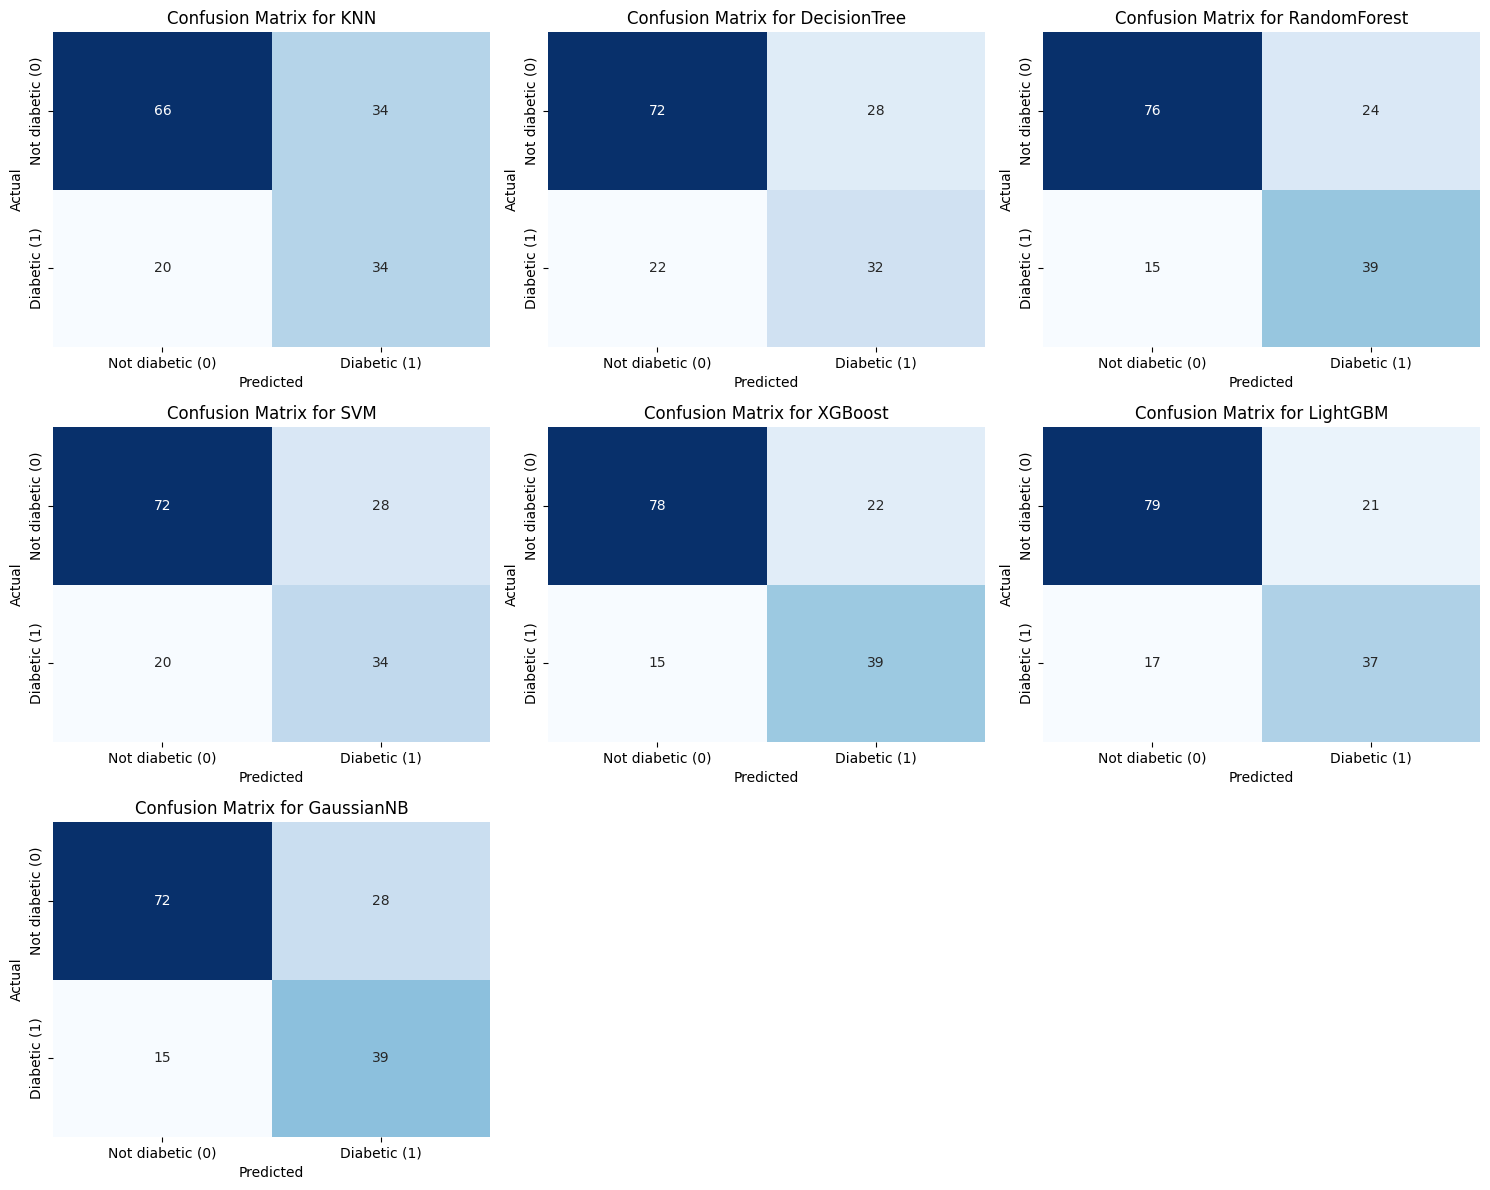

In [41]:
# Gerar Matriz de Confusão de cada modelo que foi treinado no fine tuning

# Carregar resultados do GridSearchCV a partir dos arquivos gerados
OUT_DIR = "models_output"
results_tuned = joblib.load(os.path.join(OUT_DIR, "cv_gridsearch_results_with_smote.joblib"))

# Determinar o numero de modelos para calcular as dimensões dos gráficos
num_models = len(results_tuned)
ncols = 3  # numero de colunas para os subplots
nrows = math.ceil(num_models / ncols) # calcula quantidade de linhas necessarias

# Criar figura com grid de subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 4))
axes = axes.flatten() # Achata o array 2D como 1D para facilitar iteração

# Plota cada matriz de confusão
for i, (name, result) in enumerate(results_tuned.items()):
    print(f"Generating Confusion Matrix for {name}...")

    # Carrega o melhor estimador do modelo atual
    model_path = result['model_path']
    best_estimator = joblib.load(model_path)

    # Fazer previsões no conjunto de teste
    y_test_pred = best_estimator.predict(X_test)

    # Gerar matriz de confusao
    cm = confusion_matrix(y_test, y_test_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not diabetic (0)', 'Diabetic (1)'],
                yticklabels=['Not diabetic (0)', 'Diabetic (1)'], ax=axes[i])
    axes[i].set_title(f'Confusion Matrix for {name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

# Remove qualquer subplot nao usado
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Ajusta layout para previnir sobreposição de titles/labels
plt.show()

As melhores matrizes de confusão, cujo desempenho estão bem parecidos são o do XGBoost e a RandomForest.

## 8. COMPARARIVO DE PERFORMANCES

A curva ROC (**Receiver Operating Characteristic** ou Característica Operacional do Receptor, em português) é um gráfico usado para avaliar o desempenho de modelos de classificação binária. Ela plota a **Taxa de Verdadeiros Positivos (sensibilidade)** no eixo Y contra a **Taxa de Falsos Positivos (1 - especificidade)** no eixo X para todos os possíveis limiares de decisão. Uma curva mais próxima do canto superior esquerdo indica um modelo com melhor desempenho. Vamos plotar essa curva para determinar os modelos com melhores desempenhos.

Generating ROC curve for KNN...
Generating ROC curve for DecisionTree...
Generating ROC curve for RandomForest...
Generating ROC curve for SVM...
Generating ROC curve for XGBoost...
Generating ROC curve for LightGBM...
Generating ROC curve for GaussianNB...


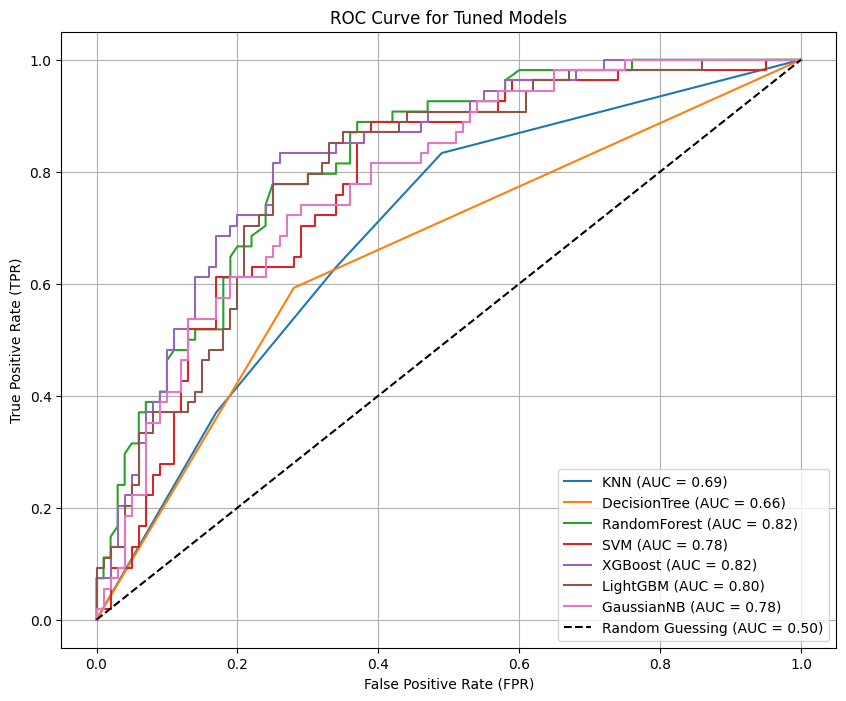

In [42]:
# Gerar curva roc para cada modelo

# Carregar resultados do GridSearchCV a partir dos arquivos gerados
OUT_DIR = "models_output"
results_tuned = joblib.load(os.path.join(OUT_DIR, "cv_gridsearch_results_with_smote.joblib"))

plt.figure(figsize=(10, 8))

# iterar em cada modelo fined tuned
for name, result in results_tuned.items():
    print(f"Generating ROC curve for {name}...")

    # Carregar o melhor estimador para o modelo atual
    model_path = result['model_path']
    best_estimator = joblib.load(model_path)

    # Probabilidade previstas para a classe positiva
    # Usa predict_proba se disponível, caso contrário use decision_function
    try:
        y_test_proba = best_estimator.predict_proba(X_test)[:, 1]
    except Exception:
        try:
            y_test_proba = best_estimator.decision_function(X_test)
        except Exception:
            print(f"Could not get probabilities or scores for {name}. Skipping ROC curve.")
            continue # Pule plotagem caso não tenha conseguido gerar as probabilidades


    # Calcula curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

    # Calcula area abaixo da curva
    auc = roc_auc_score(y_test, y_test_proba)

    # Plot a curva ROC
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

# Plot a linnha de palpite aleatório
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.50)')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Tuned Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

O XGBoost com 0.82 e a RandomForest com 0.81 são os melhores modelos. Mas o XGBoost foi superior na métrica F1-Score e na matriz de confusão.

## 9. EXPLICABILIDADE

O Melhor modelo pela curva ROC foi o **XGBoost**. Vamos plotar a explicabilidade dele usando SHAP.

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Generating SHAP Summary Plot...



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


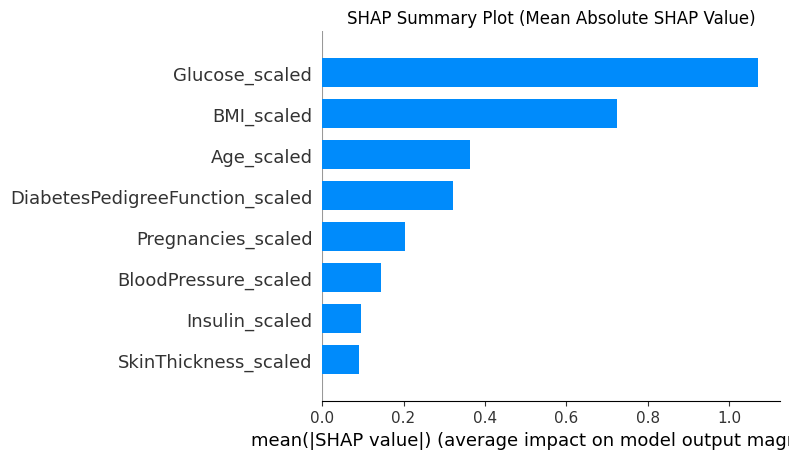

Generating SHAP Summary Plot (Distribution)...


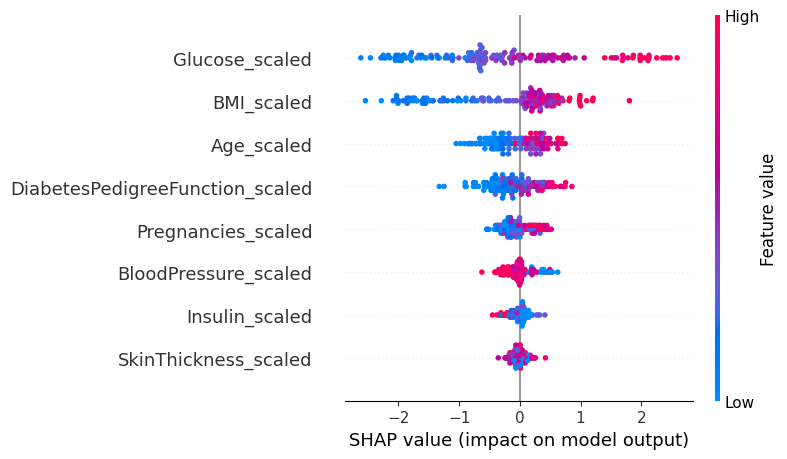

In [43]:
# Import lib para explicabilidade | versão especifica do xgboost, pois a 3.1.0 deu problema
!pip install shap
!pip install xgboost==3.0.0
# Then, you can verify the installed version
# import xgboost as xgb
# print(f"XGBoost version: {xgb.__version__}")

import shap
import os

# Carregar o modelo XGBoost
OUT_DIR = "models_output"
model_path = os.path.join(OUT_DIR, "XGBoost_pipeline_tuned.joblib")
best_estimator = joblib.load(model_path)

# Extrair o modelo XGBoost model do pipeline
# O estimador é o último passo do pipeline
xgb_model = best_estimator.named_steps['clf']

# Criar SHAP para explicabilidade
# Usa os dados de treinamento para estimar distribuição
explainer = shap.TreeExplainer(xgb_model)

shap_values = explainer.shap_values(X_test)

# Se shap_values for uma list of arrays (comum para problemas binários e multi-classe)
# seleciona os valores para a classe positiva (classe 1 - Diabético)
if isinstance(shap_values, list):
    shap_values = shap_values[1]

plt.figure(figsize=(10, 6))

# Criar DataFrame para valores SHAP para melhor visualização com nomes das features
# É necessário obter as features originais com num_features_cols
feature_names = [f"{c}_scaled" for c in num_features_cols] # usando scaled pois dados treinados nele
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Visualizar SHAP com o impacto de cada feature
print("Generating SHAP Summary Plot...")
shap.summary_plot(shap_values, X_test_df, plot_type="bar", max_display=9, show=False)
plt.title("SHAP Summary Plot (Mean Absolute SHAP Value)")
plt.tight_layout() # Ajusta layout para previnir sobreposição de titles/labels
plt.show()

print("Generating SHAP Summary Plot (Distribution)...")
shap.summary_plot(shap_values, X_test_df, show=False)
plt.tight_layout() # Ajusta layout para previnir sobreposição de titles/labels
plt.show()


Analisando o gráfico de resumo SHAP, podemos entender a importância das features para o modelo XGBoost e como elas impactam na previsão da presença de diabetes.

O gráfico de barras (primeiro plot) mostra a importância global de cada feature, ordenada pela média do valor absoluto SHAP. Features com barras mais longas são as mais relevantes para o modelo. **Glucose_scaled** e **BMI_scaled** apresentam os maiores valores SHAP médios, indicando que são as features mais importantes para este modelo na previsão de diabetes.

O segundo plot (gráfico de distribuição) oferece uma visão mais detalhada: cada ponto representa uma instância no conjunto de teste, a posição horizontal do ponto indica o impacto SHAP na saída do modelo para essa instância (valores positivos empurram a previsão para a classe positiva - Diabético, e valores negativos empurram para a classe negativa - Não diabético), e a cor do ponto indica o valor da feature (vermelho para valores altos, azul para valores baixos).

Ao observar a distribuição para **Glucose_scaled**, vemos que:
*   Pontos vermelhos (altos valores de Glucose_scaled) estão concentrados no lado direito do gráfico, indicando que altos níveis de glicose aumentam significativamente a probabilidade do modelo prever diabetes.
*   Pontos azuis (baixos valores de Glucose_scaled) estão concentrados no lado esquerdo, indicando que baixos níveis de glicose diminuem a probabilidade do modelo prever diabetes.

Para **BMI_scaled**, a análise é similar:
*   Pontos vermelhos (altos valores de BMI_scaled) tendem a estar mais à direita no gráfico, mostrando que um Índice de Massa Corporal elevado contribui para a previsão de diabetes.
*   Pontos azuis (baixos valores de BMI_scaled) estão mais à esquerda, indicando que um BMI baixo contribui para a previsão de não diabetes.

Essas observações confirmam que **Glucose** e **BMI** são features cruciais para o modelo XGBoost, com valores mais altos em ambas as variáveis sendo fortes indicadores para a previsão de diabetes, enquanto valores mais baixos indicam o oposto. As outras features também contribuem, mas com um impacto médio menor na decisão do modelo.

## 10. PRODUTIZAÇÃO

O objetivo da **Produtização** é transformar o modelo de **Machine Learning** treinado em um serviço confiável de inferência; isso inclui serializar o artefato do modelo e do pré‑processamento em um formato apropriado (**joblib**), expor uma API leve em Python com Flask que receba entradas (as features ou características), execute as transformações e retorne previsões. Além disso, criar um Dockerfile que permite buildar uma imagem e executar um container com a aplicação, facilitando implantações.

### 10.1 SALVAR O PIPELINE DE PREVISÃO
Combine the preprocessor and the best-tuned Random Forest model into a single pipeline and save it using `joblib`.


Vamos combinar o pipeline criado no pré-processamento, o qual preenchia valores ausentes e, em seguida, fazia a padronização dos dados para ficarem com escala parecida, com o pipeline que fazia o treinamento/previsão do melhor modelo (**XGBoost**) do fine tuning.

In [44]:
# ======================================================================================
# Carrega os modelos do preprocessador e do melhor modelo XGBoost do fine tuning
# ======================================================================================
preprocessor = joblib.load("preprocessor.joblib")
best_rf_pipeline = joblib.load(os.path.join(OUT_DIR, "XGBoost_pipeline_tuned.joblib"))

# Extrai o Random Forest model do pipeline
rf_model = best_rf_pipeline.named_steps['clf']

# Cria um novo pipeline que inclui o preprocessor e o melhor modelo
full_prediction_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                          ('classifier', rf_model)])

# SALVA o pipeline completo
joblib.dump(full_prediction_pipeline, os.path.join(OUT_DIR, "full_prediction_pipeline.joblib"))

print("Full prediction pipeline saved successfully.")

Full prediction pipeline saved successfully.


### 10.2. CRIAR SCRIPT PYTHON DE PREDIÇÃO

Vamos criar um script python com uma função que carrega o pipeline completo e faz previsão baseado nas features de entrada

In [45]:
%%writefile predict_script.py

import joblib
import pandas as pd
import os

# Path para a pasta onde  foi salvo o pipeline completo
OUT_DIR = "models_output"
PIPELINE_PATH = os.path.join(OUT_DIR, "full_prediction_pipeline.joblib")

# Carrega o pipeline de previsão
try:
    loaded_pipeline = joblib.load(PIPELINE_PATH)
    print("Prediction pipeline loaded successfully.")
except FileNotFoundError:
    print(f"Error: Pipeline file not found at {PIPELINE_PATH}")
    loaded_pipeline = None

# Lista de features originais
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

def predict_diabetes(data_point):
    """
    Preve se a pessoa é diabética ou não usando a pipeline completa.
    Args:
        data_point (dict): Um dicionário que representa um paciente
        com keys correspondentes aos nomes das features originais.

    Returns:
        int: Diabetes (1 para diabético, 0 para não diabético)
    """
    if loaded_pipeline is None:
        return None

    # Converte os dados de entrada em pandas DataFrame
    # Assegurar a ordem das colunas batem com os dados de treinamentos
    input_df = pd.DataFrame([data_point], columns=feature_names)

    # Fazer previsão
    prediction = loaded_pipeline.predict(input_df)

    # A previsao é um numpy array, returne o primeiro elemento
    return int(prediction[0])

if __name__ == '__main__':
    # Examplo de uso para teste do script diretamente
    # Troque o valor pelos dados de vdd
    sample_data = {
        'Pregnancies': 2.0,
        'Glucose': 100.0,
        'BloodPressure': 80.0,
        'SkinThickness': 32.0,
        'Insulin': 80.0,
        'BMI': 32.0,
        'DiabetesPedigreeFunction': 0.37,
        'Age': 29.0
    }

    prediction = predict_diabetes(sample_data)

    if prediction is not None:
        print(f"Sample data: {sample_data}")
        print(f"Predicted diabetes: {prediction}")
    else:
        print("Prediction failed due to pipeline loading error.")


Writing predict_script.py


### 10.3. CRIA ARQUIVO DE APLICAÇÃO DE UM WEB SERVER COM FLASK


Cria um arquivo de aplicação **app.py** que importa tudo que é necessário, inicializa a aplicação e torna disponível um endpoint de fazer previsão **/prediction**. Além disso, integramos o Swagger UI para prover uma documentação de API interativa.

In [46]:
!pip install flask-swagger-ui

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
%%writefile app.py

from flask import Flask, request, jsonify, redirect
import sys
import os
from flask_swagger_ui import get_swaggerui_blueprint

# Para o google colab exite uma pasta content/
if '/content/' not in sys.path:
    sys.path.append('/content/')

# Importar função de previsão do script
try:
    from predict_script import predict_diabetes
    print("Successfully imported predict_diabetes function.")
except ImportError as e:
    print(f"Error importing predict_diabetes: {e}")
    predict_diabetes = None


app = Flask(__name__)


# Define Swagger UI configuration
SWAGGER_URL = '/swagger'  # URL para acessar Swagger UI
API_URL = '/static/swagger.json' # Nossa Swagger spec é servida daqui

swaggerui_blueprint = get_swaggerui_blueprint(
    SWAGGER_URL,
    API_URL,
    config={
        'app_name': "Diabetes Prediction API"
    }
)

app.register_blueprint(swaggerui_blueprint, url_prefix=SWAGGER_URL)

# Define a especificação do Swagger
SWAGGER_SPEC = {
    "swagger": "2.0",
    "info": {
        "version": "1.0.0",
        "title": "Diabetes Prediction API"
    },
    "paths": {
        "/predict": {
            "post": {
                "summary": "Diabetes Prediction API",
                "consumes": ["application/json"],
                "produces": ["application/json"],
                "parameters": [
                    {
                        "in": "body",
                        "name": "body",
                        "description": "Patient clinical and biometric features",
                        "required": True,
                        "schema": {
                            "type": "object",
                            "properties": {
                                "Pregnancies": {"type": "number"},
                                "Glucose": {"type": "number"},
                                "BloodPressure": {"type": "number"},
                                "SkinThickness": {"type": "number"},
                                "Insulin": {"type": "number"},
                                "BMI": {"type": "number"},
                                "DiabetesPedigreeFunction": {"type": "number"},
                                "Age": {"type": "number"}
                            },
                            "example": {
                                'Pregnancies': 2.0,
                                'Glucose': 100.0,
                                'BloodPressure': 80.0,
                                'SkinThickness': 32.0,
                                'Insulin': 80.0,
                                'BMI': 32.0,
                                'DiabetesPedigreeFunction': 0.37,
                                'Age': 29.0
                            }
                        }
                    }
                ],
                "responses": {
                    "200": {
                        "description": "Successful prediction",
                        "schema": {
                            "type": "object",
                            "properties": {
                                "prediction": {"type": "integer", "description": "0 for non-diabetic, 1 for diabetic"},
                                "description": {"type": "string", "description": "Human-readable prediction"}
                            }
                        }
                    },
                    "400": {
                        "description": "Invalid input"
                    },
                    "500": {
                        "description": "Internal server error"
                    }
                }
            }
        }
    }
}

# Route que serve o Swagger JSON spec
@app.route(API_URL)
def swagger_spec():
    return jsonify(SWAGGER_SPEC)


@app.route('/predict', methods=['POST'])
def predict():
    """
    Recebe um JSON payload com as features de uma amostra de água,
    prevê se um paciente é diabético ou nao e retorna o resultado.
    """
    if predict_diabetes is None:
        return jsonify({"error": "Prediction function not loaded."}), 500

    try:
        data = request.get_json(force=True)
        # Assumindo que o JSON de entrada tem keys que bate com os nomes das features
        # ex.: {'Pregnancies': 2.0, 'Glucose': 100.0, ...}

        # Fazer previsão
        prediction = predict_diabetes(data)

        if prediction is not None:
            result = {
                'prediction': prediction,
                'description': 'Pacient is diabetic' if prediction == 1 else 'Pacient is non-diabetic'
            }
            return jsonify(result)
        else:
            return jsonify({"error": "Prediction failed."}), 500

    except Exception as e:
        return jsonify({"error": str(e)}), 400


# Redireciona a raiz "/" para a documentação Swagger
@app.route('/')
def redirect_to_swagger():
    return redirect('/swagger', code=302)


if __name__ == '__main__':
    # Execute a aplicação Flask
    app.run(host='0.0.0.0', port=5000)


Writing app.py


### 10.4. DOCKERFILE

Vamos criar um arquivo Dockerfile com tudo que é necessário para buildar uma imagem da nossa aplicação, tornando-a portátil e de fácil implantação.

In [48]:
%%writefile Dockerfile

# Use um imagem python oficial como base
FROM python:3.13-slim

# Defin diretório de trabalho onde as próximas diretivas serão executadas
WORKDIR /app

# Copia o conteudo do diretório atual para dentro do container em /app
COPY . /app

# Instala as dependências especificadas em requirements.txt
RUN pip install --no-cache-dir -r requirements.txt

# Faz a porta 5000 dentro do container ficar disponivel pro exterior
EXPOSE 5000

# Executa a aplicação
CMD ["gunicorn", "--bind", "0.0.0.0:5000", "app:app"]


Writing Dockerfile


### 10.5. ARQUIVO DE DEPENDÊNCIAS DO PROJETO

Gera um arquivo `requirements.txt` com as libraries necessárias para aplicação Flask e script de previsão. Não é obrigatório fixar com a versão, mas mantive para deixar salvo qual foi a versão usada localmente.

In [49]:
%%writefile requirements.txt
Flask==3.1.2
joblib==1.5.2
pandas==2.3.2
scikit-learn==1.6.1
flask-swagger-ui==5.21.0
gunicorn==23.0.0
shap==0.49.1
numpy==2.3.2
scipy==1.16.1
packaging==25.0
slicer==0.0.8
numba==0.62.1
cloudpickle==3.1.1
typing_extensions==4.15.0
llvmlite==0.45.1
python-dateutil==2.9.0.post0
pytz==2025.2
tzdata==2025.2
threadpoolctl==3.6.0
xgboost==3.0.0


Overwriting requirements.txt


### 10.6. TESTAR A API LOCALMENTE

Organização dos arquivos e pastas do projeto:
```bash
./
├── app.py
├── Dockerfile
├── notebook.ipynb
├── predict_script.py
├── requirements.txt
└── models_output/
    └── *.joblib  (todos os arquivos da modelagem)
```

Abra o terminal e navegue até a raiz do projeto, onde estão **app.py** e **predict_script.py**.

Instale as dependências do projeto, tomando como base o arquivo de `requirements.txt`:

```bash
pip install -r requirements.txt
```

Aplique o comando a seguir para executar a aplicação:
```bash
python app.py
```
Isso inicia a aplicação em [http://localhost:5000](http://localhost:5000) ou [http://127.0.0.1:5000](http://127.0.0.1:5000).
A aplicação tem um redirecionamento, onde requisições para a raiz mandam o usuário para a documentação do swagger:

- [http://localhost:5000/swagger](http://localhost:5000/swagger)
- [http://127.0.0.1:5000/swagger](http://127.0.0.1:5000/swagger)

Para testar, você pode fazer uma requisição pelo terminal usando **cURL**, como no exemplo abaixo:

```bash
curl -X 'POST' \
  'http://127.0.0.1:5000/predict' \
  -H 'accept: application/json' \
  -H 'Content-Type: application/json' \
  -d '{
    "Pregnancies": 2.0,
    "Glucose": 100.0,
    "BloodPressure": 80.0,
    "SkinThickness": 32.0,
    "Insulin": 80.0,
    "BMI": 32.0,
    "DiabetesPedigreeFunction": 0.37,
    "Age": 29.0
}'
```

Opcionalmente, acesse o endpoint na documentação  [http://localhost:5000/swagger](http://localhost:5000/swagger), clique em **Try it out**; edite os valores do body conforme desejado. Por fim, clique no botão **Execute**. Você receberá uma resposta parecida com essa:

```bash
{
  "description": "Pacient is non-diabetic",
  "prediction": 0
}
```


### 10.7. CICLO DE VIDA DA APLICAÇÃO DENTRO DE UM CONTAINER DOCKER

Caso tenha Docker instalado, [Download aqui](https://www.docker.com/products/docker-desktop/), é possível criar um container a partir do Dockerfile que está presente na raiz do projeto.

Para fazer o build da imagem docker da aplicação, execute o seguinte comando a partir da raiz do projeto:

```bash
docker build -t flask-diabetes-app .
```
Isso cria uma imagem chamada **flask-diabetes-app**.

Para inicializar a aplicação dentro de um container a partir dessa imagem, execute o comando abaixo:

```bash
docker run -d -p 5000:5000 --name flask-diabetes-container flask-diabetes-app
```
Isso inicia a aplicação dentro do container. A opção **-p** (publish) mapeia a porta 5000 do seu computador local para a 5000 dentro do container. Desse modo, ao acessar [http://localhost:5000](http://localhost:5000) você consegue acessar a aplicação que está dentro do container e fazer interações com ele.

Os testes são exatamente os mesmos do item anterior, com a vantagem de que sua aplicação está portátil e de fácil implantação em outros ambientes de outros computadores, pois é agnóstico ao sistema operacional, sendo necessário apenas que o hospedeiro tenha docker instalado.

Quando estiver satisfeito e deseje encerrar os comandos a seguir finalizam a execução.
Parar o container e, dessa forma, encerrar a disponibilidade da aplicação:
```bash
docker stop flask-diabetes-container
```

Remover o container criado:
```bash
docker rm flask-diabetes-container
```
Remover a imagem de container criada a partir do Dockerfile:
```bash
docker rmi flask-diabetes-app
```



## 11. COMO FAZER DOWNLOAD CASO EXECUTE NO GOOGLE COLAB

Instruções sobre como baixar o arquivo do notebook (.ipynb), scripts Python (.py) e arquivos de modelo salvos (.joblib) do ambiente Google Colab.

In [50]:
# gera um zip com todo o conteudo criado, excluindo diretorios do sistema proprio do colab
# !zip -r project_content.zip . -x ".config/*" "__pycache__/*" "*.ipynb_checkpoints/*" "sample_data/*" "drive/*"

In [51]:
# # Remova os comentários e execute a célula para fazer o download do zip
# # faz download do conteudo
# from google.colab import files
# files.download("project_content.zip")